In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import FactorAnalysis
from scipy.stats import linregress
from sklearn.model_selection import KFold

from pytorch_stats_model_multi_dim import * 

import glob, h5py
from tqdm import tqdm
from sklearn.metrics import r2_score 
import pickle

from scipy.optimize import least_squares

In [4]:
%matplotlib notebook
import seaborn as sns
sns.set()
sns.set_style("whitegrid", {'axes.grid' : False, 'axes.labelcolor': '0', 'text.color':'0', 'xtick.color':'0', 'ytick.color':'0'}),

SMALL_SIZE = 12
MEDIUM_SIZE = 21
BIGGER_SIZE = 21

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [5]:
data_file = sorted(glob.glob('./dataset/dataset1/*.mat'))
f = h5py.File(data_file[4],'r')
ref_spikes = f['spikes']
ref_stim = f['stim']
V1_spks = np.array(f[ref_spikes[0,0]]) #3200 trials x 1280 ms x n1
V2_spks = np.array(f[ref_spikes[1,0]]) #3200 trials x 1280 ms x n2
stim = np.array(f.get('/stim')) # 1x3200 trials

n_trial, T, n1 = V1_spks.shape
junk, junk, n2 = V2_spks.shape
n_stim = int(np.max(stim))
print(n1, n2)

#bin the data
bin_width = 100
n_bin = int(T/bin_width)
V1_spks_binned = np.reshape(V1_spks[:, :n_bin*bin_width, :], (n_trial, bin_width, n_bin, n1), order='F')
V1_spks_binned = np.sum(V1_spks_binned, 1)

V2_spks_binned = np.reshape(V2_spks[:, :n_bin*bin_width, :], (n_trial, bin_width, n_bin, n2), order='F')
V2_spks_binned = np.sum(V2_spks_binned, 1)

stim_order = np.argsort(stim[0,:])
V1_spks_binned = V1_spks_binned[stim_order,:,:]
V1_tmp = np.mean(V1_spks_binned[:400, :, :],0)
neuron_order = np.argsort(np.max(V1_tmp,0)) #order neuron based on their peak responses during orientaton 0

V2_spks_binned = V2_spks_binned[stim_order,:,:]
V2_tmp = np.mean(V2_spks_binned[:400, :, :],0)
neuron_order2 = np.argsort(np.max(V2_tmp,0))


V1_tuning = np.zeros((n1,n_stim))
V2_tuning = np.zeros((n2,n_stim))
for stim_i in range(n_stim):
    V1_tuning[:, stim_i] = np.mean(V1_spks_binned[400*stim_i: 400*(stim_i+1),int(100/bin_width):,:],(0,1)) # (n1,)
    V2_tuning[:, stim_i] = np.mean(V2_spks_binned[400*stim_i: 400*(stim_i+1),int(100/bin_width):,:],(0,1)) # (n2,)


V1_f = np.sum(V1_spks_binned[:,int(100/bin_width):,:],1).T
V2_f = np.sum(V2_spks_binned[:,int(100/bin_width):,:],1).T


111 37


In [146]:
def soft_cluster(f):
    # cluster based on score of maximum absolute value
    cluster_ids = np.argmax(np.abs(f), axis=1)
    scores = f[range(f.shape[0]), cluster_ids]

    # resort within each cluster
    perm = []
    for cluster in np.unique(cluster_ids):
        idx = np.where(cluster_ids == cluster)[0]
        perm += list(idx[np.argsort(scores[idx])][::-1])
    return cluster_ids, perm

#exclude silent neurons
if (V1_tuning==0).any():
    id_silent = np.unique(np.where(V1_tuning==0)[0])
    print(id_silent)
    V1_f = np.delete(V1_f, id_silent, axis=0)
    V1_tuning = np.delete(V1_tuning, id_silent, axis=0)
    n1 -= id_silent.shape[0]
    print(V1_f.shape)

if (V2_tuning==0).any():
    id_silent = np.unique(np.where(V2_tuning==0)[0])
    print(id_silent)
    V2_f = np.delete(V2_f, id_silent, axis=0)
    V2_tuning = np.delete(V2_tuning, id_silent, axis=0)
    n2 -= id_silent.shape[0]
    print(V2_f.shape)

pref_ori_V1, tuning_order_V1 = soft_cluster(V1_tuning)
pref_ori_V2, tuning_order_V2 = soft_cluster(V2_tuning)

n1,n2

(111, 37)

In [147]:
def calculate_OTI_direct(V1_tuning):
    
    tuning = V1_tuning
    max_tuning = np.max(tuning,1)
    min_tuning = np.min(tuning,1)

    OTI = (max_tuning-min_tuning)/(max_tuning+min_tuning)
    return OTI

In [148]:
OTI_V1_direct = calculate_OTI_direct(V1_tuning)
OTI_V2_direct = calculate_OTI_direct(V2_tuning)

In [149]:
thr = 0.35
print(len(np.where(OTI_V1_direct>thr)[0]))
print(len(np.where(OTI_V2_direct>thr)[0]))


59
29


In [150]:
n1 = np.sum(OTI_V1_direct>thr)
n2 = np.sum(OTI_V2_direct>thr)

V1_f_new = V1_f[OTI_V1_direct>thr, :]
V2_f_new = V2_f[OTI_V2_direct>thr, :]

V1_f= V1_f_new
V2_f= V2_f_new

V1_tuning = V1_tuning[OTI_V1_direct>0.35,:]
V2_tuning = V2_tuning[OTI_V2_direct>0.35,:]

pref_ori_V1, tuning_order_V1 = soft_cluster(V1_tuning)
pref_ori_V2, tuning_order_V2 = soft_cluster(V2_tuning)

In [151]:
n_trial =400
V1_f_ = V1_f.reshape((n1, n_trial, n_stim), order='F')
V2_f_ = V2_f.reshape((n2, n_trial, n_stim), order='F')
n_trial_train = 320
n_trial_test = 80

## Fit statistical models

In [36]:
aff_model_V1_all = [] # affine model fit to V1 data
mul_model_V1_all = [] # multiplicative model fit to V1 data
add_varp_model_V1_all = [] # additive model fit to V1 data
gen_model_V1_all = [] # generalized model fit to V1 data
add_model_V1_all = [] # This is NOT the additive model used in Xia et al 2023, this additive model assumes stimulus-independent private variability
expo_model_V1_all = [] # This model is not used in Xia et al 2023

# same set of statistical models fit to V2 data
aff_model_V2_all = []
mul_model_V2_all = []
add_varp_model_V2_all = []
gen_model_V2_all = []
add_model_V2_all = []
expo_model_V2_all = []

# index of trials in 5-fold cross-validation
train_ind_all = []
test_ind_all = []

kf = KFold(n_splits=5,shuffle=True)
split=0

for train_ind, test_ind in tqdm(kf.split(np.arange(n_trial))):        
    split += 1
    
    V1_f_train = V1_f_[:,train_ind,:].reshape((n1, -1), order='F')
    V1_f_test = V1_f_[:,test_ind,:].reshape((n1, -1), order='F')
    
    V2_f_train = V2_f_[:,train_ind,:].reshape((n2, -1), order='F')
    V2_f_test = V2_f_[:,test_ind,:].reshape((n2, -1), order='F')
    
    x1 = V1_f_train.reshape(n1, -1, order='F')
    x_test1 = V1_f_test.reshape(n1, -1, order='F')
    
    x2 = V2_f_train.reshape(n2, -1, order='F')
    x_test2 = V2_f_test.reshape(n2, -1, order='F')

    train_ind_all.append(train_ind)
    test_ind_all.append(test_ind)
    
    for n_compo in range(1,6):

        gen_model_V1 = generalized_model(x1, n1, n_stim, n_trial_train, x_test1, n_trial_test, n_compo)
        add_model_V1 = additive_model(x1, n1, n_stim, n_trial_train, x_test1, n_trial_test, n_compo)

        gen_model_V1_all.append(gen_model_V1)
        add_model_V1_all.append(add_model_V1)
        
        #########
        gen_model_V2 = generalized_model(x2, n2, n_stim, n_trial_train, x_test2, n_trial_test, n_compo)
        add_model_V2 = additive_model(x2, n2, n_stim, n_trial_train, x_test2, n_trial_test, n_compo)

        gen_model_V2_all.append(gen_model_V2)
        add_model_V2_all.append(add_model_V2)
        
        
        ########
        beta_p_init = add_model_V1.h_p.copy()
        psi_p_init = gen_model_V1.psi_p.copy()
        expo_p_init = 0.5
        
        expo_model_V1 = exponent_model(x1, n1, n_stim, n_trial_train, n_compo, expo_p_init, beta_p_init, psi_p_init)
        junk = expo_model_V1.train(1e-2, x1, n_trial_train)
        
        expo_model_V1_all.append(expo_model_V1)
        ########
        
        beta_p_init = add_model_V2.h_p.copy()
        psi_p_init = gen_model_V2.psi_p.copy()
        expo_p_init = 0.5
        
        expo_model_V2 = exponent_model(x2, n2, n_stim, n_trial_train, n_compo, expo_p_init, beta_p_init, psi_p_init)
        junk = expo_model_V2.train(1e-2, x2, n_trial_train)
        
        expo_model_V2_all.append(expo_model_V2)
        
        
        #########
        h_p_init = add_model_V1.h_p.copy()
        psi_p_init = gen_model_V1.psi_p.copy()

        add_varp_model_V1 = additive_varp_model(x1, n1, n_stim, n_trial_train, n_compo, h_p_init, psi_p_init)
        d_add_varp_V1, h_add_varp_V1, psi_add_varp_V1 = add_varp_model_V1.train(1e-2, x1, n_trial_train)

        add_varp_model_V1_all.append(add_varp_model_V1) 
        
        ###################################
        h_p_init = add_model_V2.h_p.copy()
        psi_p_init = gen_model_V2.psi_p.copy()

        add_varp_model_V2 = additive_varp_model(x2, n2, n_stim, n_trial_train, n_compo, h_p_init, psi_p_init)
        d_add_varp_V2, h_add_varp_V2, psi_add_varp_V2 = add_varp_model_V2.train(1e-2, x2, n_trial_train)

        add_varp_model_V2_all.append(add_varp_model_V2) 
        
        
        ##############
        alpha_p_init = np.zeros((n1, n_compo))
        beta_p_init = add_model_V1.h_p.copy()
        psi_p_init = gen_model_V1.psi_p.copy()

        aff_model_V1 = affine_model(x1, n1, n_stim, n_trial_train, n_compo, alpha_p_init, beta_p_init, psi_p_init)
        d_aff_V1, alpha_aff_V1, beta_aff_V1, psi_aff_V1 = aff_model_V1.train(1e-2, x1, n_trial_train)

        aff_model_V1_all.append(aff_model_V1)
        
        
        ##############
        alpha_p_init = np.zeros((n2, n_compo))
        beta_p_init = add_model_V2.h_p.copy()
        psi_p_init = gen_model_V2.psi_p.copy()

        aff_model_V2 = affine_model(x2, n2, n_stim, n_trial_train, n_compo, alpha_p_init, beta_p_init, psi_p_init)
        d_aff_V2, alpha_aff_V2, beta_aff_V2, psi_aff_V2 = aff_model_V2.train(1e-2, x2, n_trial_train)

        aff_model_V2_all.append(aff_model_V2)
        
        #############
        print('mul model')
        psi_p_init = aff_model_V1.psi_p.detach().numpy().copy()
        alpha_p_init = aff_model_V1.alpha_p.detach().numpy().copy()
        
        mul_model_V1 = multiplicative_model(x1, n1, n_stim, n_trial_train, n_compo, alpha_p_init, psi_p_init)
        junk = mul_model_V1.train(5e-3, x1, n_trial_train)
        mul_model_V1_all.append(mul_model_V1)
        
        ##########
        psi_p_init = aff_model_V2.psi_p.detach().numpy().copy()
        alpha_p_init = aff_model_V2.alpha_p.detach().numpy().copy()
        
        mul_model_V2 = multiplicative_model(x2, n2, n_stim, n_trial_train, n_compo, alpha_p_init, psi_p_init)
        junk = mul_model_V2.train(5e-3, x2, n_trial_train)
        mul_model_V2_all.append(mul_model_V2)
        
        

0it [00:00, ?it/s]

test NLL:  318.5259151749465 train NLL:  319.22872183485396
test NLL:  339.3862122328675 train NLL:  341.0472207480519
test NLL:  49.068877353033095 train NLL:  49.88143072109537
test NLL:  54.43912288406241 train NLL:  55.2485230251563
Iteration: 1, Loss: 326.71, test Loss:  326.71
learning rate:  [0.0096]
Iteration: 501, Loss: 320.14, test Loss:  320.14
learning rate:  [0.009215999999999998]
Iteration: 1001, Loss: 319.94, test Loss:  319.94
learning rate:  [0.008847359999999999]
Iteration: 1501, Loss: 319.90, test Loss:  319.90
learning rate:  [0.008493465599999998]
Iteration: 2001, Loss: 319.89, test Loss:  319.89
learning rate:  [0.008153726975999998]
Iteration: 2501, Loss: 319.89, test Loss:  319.89
learning rate:  [0.007827577896959998]
Iteration: 3001, Loss: 319.89, test Loss:  319.89
learning rate:  [0.007514474781081598]
Iteration: 3501, Loss: 319.89, test Loss:  319.89
learning rate:  [0.007213895789838334]
Iteration: 4001, Loss: 319.89, test Loss:  319.89
learning rate:  [0.

Iteration: 6501, Loss: 50.24, test Loss:  50.24
learning rate:  [0.005646733123551133]
Iteration: 7001, Loss: 50.24, test Loss:  50.24
learning rate:  [0.0054208637986090874]
Iteration: 7501, Loss: 50.24, test Loss:  50.24
learning rate:  [0.005204029246664724]
Iteration: 8001, Loss: 50.23, test Loss:  50.23
learning rate:  [0.004995868076798135]
Iteration: 8501, Loss: 50.23, test Loss:  50.23
learning rate:  [0.00479603335372621]
Iteration: 9001, Loss: 50.23, test Loss:  50.23
learning rate:  [0.004604192019577161]
Iteration: 9501, Loss: 50.23, test Loss:  50.23
learning rate:  [0.004420024338794074]
Iteration: 10001, Loss: 50.23, test Loss:  50.23
learning rate:  [0.004243223365242311]
Iteration: 10501, Loss: 50.22, test Loss:  50.22
learning rate:  [0.0040734944306326185]
Iteration: 11001, Loss: 50.22, test Loss:  50.22
learning rate:  [0.003910554653407314]
Iteration: 11501, Loss: 50.22, test Loss:  50.22
learning rate:  [0.003754132467271021]
Iteration: 12001, Loss: 50.22, test Lo

Iteration: 8501, Loss: 320.60, test Loss:  320.60
learning rate:  [0.002398016676863105]
Iteration: 9001, Loss: 320.60, test Loss:  320.60
learning rate:  [0.0023020960097885805]
Iteration: 9501, Loss: 320.60, test Loss:  320.60
Stop: Iteration: 9501, old test Loss: 320.60251, new test Loss: 320.60252
Iteration: 1, Loss: 50.33, test Loss:  50.33
learning rate:  [0.0048]
Iteration: 501, Loss: 50.10, test Loss:  50.10
learning rate:  [0.004607999999999999]
Iteration: 1001, Loss: 50.10, test Loss:  50.10
learning rate:  [0.004423679999999999]
Iteration: 1501, Loss: 50.10, test Loss:  50.10
learning rate:  [0.004246732799999999]
Iteration: 2001, Loss: 50.10, test Loss:  50.10
learning rate:  [0.004076863487999999]
Iteration: 2501, Loss: 50.10, test Loss:  50.10
learning rate:  [0.003913788948479999]
Iteration: 3001, Loss: 50.10, test Loss:  50.10
learning rate:  [0.003757237390540799]
Iteration: 3501, Loss: 50.10, test Loss:  50.10
learning rate:  [0.003606947894919167]
Iteration: 4001, Lo

Iteration: 17001, Loss: 49.46, test Loss:  49.46
learning rate:  [0.002396034992713987]
Iteration: 17501, Loss: 49.46, test Loss:  49.46
learning rate:  [0.0023001935930054276]
Iteration: 18001, Loss: 49.46, test Loss:  49.46
learning rate:  [0.0022081858492852104]
Iteration: 18501, Loss: 49.46, test Loss:  49.46
learning rate:  [0.002119858415313802]
Iteration: 19001, Loss: 49.46, test Loss:  49.46
learning rate:  [0.00203506407870125]
Iteration: 19501, Loss: 49.46, test Loss:  49.46
learning rate:  [0.0019536615155531997]
Iteration: 1, Loss: 326.30, test Loss:  326.30
learning rate:  [0.0096]
Iteration: 501, Loss: 321.55, test Loss:  321.55
learning rate:  [0.009215999999999998]
Iteration: 1001, Loss: 321.39, test Loss:  321.39
learning rate:  [0.008847359999999999]
Iteration: 1501, Loss: 321.32, test Loss:  321.32
learning rate:  [0.008493465599999998]
Iteration: 2001, Loss: 321.28, test Loss:  321.28
learning rate:  [0.008153726975999998]
Iteration: 2501, Loss: 321.25, test Loss:  

Iteration: 5501, Loss: 317.83, test Loss:  317.83
learning rate:  [0.006127097573297671]
Iteration: 6001, Loss: 317.83, test Loss:  317.83
learning rate:  [0.005882013670365764]
Iteration: 6501, Loss: 317.83, test Loss:  317.83
learning rate:  [0.005646733123551133]
Iteration: 7001, Loss: 317.83, test Loss:  317.83
Stop: Iteration: 7001, old test Loss: 317.83086, new test Loss: 317.83093
Iteration: 1, Loss: 50.96, test Loss:  50.96
learning rate:  [0.0096]
Iteration: 501, Loss: 49.51, test Loss:  49.51
learning rate:  [0.009215999999999998]
Iteration: 1001, Loss: 49.48, test Loss:  49.48
learning rate:  [0.008847359999999999]
Iteration: 1501, Loss: 49.47, test Loss:  49.47
learning rate:  [0.008493465599999998]
Iteration: 2001, Loss: 49.46, test Loss:  49.46
learning rate:  [0.008153726975999998]
Iteration: 2501, Loss: 49.46, test Loss:  49.46
learning rate:  [0.007827577896959998]
Iteration: 3001, Loss: 49.45, test Loss:  49.45
learning rate:  [0.007514474781081598]
Iteration: 3501, L

Iteration: 4501, Loss: 49.67, test Loss:  49.67
learning rate:  [0.003324163179957504]
Iteration: 5001, Loss: 49.67, test Loss:  49.67
learning rate:  [0.0031911966527592038]
Iteration: 5501, Loss: 49.67, test Loss:  49.67
learning rate:  [0.0030635487866488356]
Iteration: 6001, Loss: 49.67, test Loss:  49.67
learning rate:  [0.002941006835182882]
Iteration: 6501, Loss: 49.67, test Loss:  49.67
learning rate:  [0.0028233665617755665]
Iteration: 7001, Loss: 49.67, test Loss:  49.67
learning rate:  [0.0027104318993045437]
Iteration: 7501, Loss: 49.67, test Loss:  49.67
learning rate:  [0.002602014623332362]
Iteration: 8001, Loss: 49.67, test Loss:  49.67
learning rate:  [0.0024979340383990676]
Iteration: 8501, Loss: 49.67, test Loss:  49.67
learning rate:  [0.002398016676863105]
Iteration: 9001, Loss: 49.67, test Loss:  49.67
learning rate:  [0.0023020960097885805]
Iteration: 9501, Loss: 49.67, test Loss:  49.67
learning rate:  [0.002210012169397037]
Iteration: 10001, Loss: 49.67, test L

Iteration: 6501, Loss: 320.09, test Loss:  320.09
learning rate:  [0.005646733123551133]
Iteration: 7001, Loss: 320.08, test Loss:  320.08
learning rate:  [0.0054208637986090874]
Iteration: 7501, Loss: 320.08, test Loss:  320.08
learning rate:  [0.005204029246664724]
Iteration: 8001, Loss: 320.08, test Loss:  320.08
learning rate:  [0.004995868076798135]
Iteration: 8501, Loss: 320.07, test Loss:  320.07
learning rate:  [0.00479603335372621]
Iteration: 9001, Loss: 320.07, test Loss:  320.07
learning rate:  [0.004604192019577161]
Iteration: 9501, Loss: 320.07, test Loss:  320.07
learning rate:  [0.004420024338794074]
Iteration: 10001, Loss: 320.07, test Loss:  320.07
learning rate:  [0.004243223365242311]
Iteration: 10501, Loss: 320.07, test Loss:  320.07
learning rate:  [0.0040734944306326185]
Iteration: 11001, Loss: 320.07, test Loss:  320.07
learning rate:  [0.003910554653407314]
Iteration: 11501, Loss: 320.07, test Loss:  320.07
learning rate:  [0.003754132467271021]
Iteration: 12001

Iteration: 5001, Loss: 49.13, test Loss:  49.13
learning rate:  [0.0063823933055184075]
Iteration: 5501, Loss: 49.13, test Loss:  49.13
learning rate:  [0.006127097573297671]
Iteration: 6001, Loss: 49.12, test Loss:  49.12
learning rate:  [0.005882013670365764]
Iteration: 6501, Loss: 49.12, test Loss:  49.12
learning rate:  [0.005646733123551133]
Iteration: 7001, Loss: 49.12, test Loss:  49.12
learning rate:  [0.0054208637986090874]
Iteration: 7501, Loss: 49.11, test Loss:  49.11
learning rate:  [0.005204029246664724]
Iteration: 8001, Loss: 49.11, test Loss:  49.11
learning rate:  [0.004995868076798135]
Iteration: 8501, Loss: 49.10, test Loss:  49.10
learning rate:  [0.00479603335372621]
Iteration: 9001, Loss: 49.10, test Loss:  49.10
learning rate:  [0.004604192019577161]
Iteration: 9501, Loss: 49.10, test Loss:  49.10
learning rate:  [0.004420024338794074]
Iteration: 10001, Loss: 49.10, test Loss:  49.10
learning rate:  [0.004243223365242311]
Iteration: 10501, Loss: 49.10, test Loss:

Iteration: 2001, Loss: 49.10, test Loss:  49.10
learning rate:  [0.008153726975999998]
Iteration: 2501, Loss: 49.09, test Loss:  49.09
learning rate:  [0.007827577896959998]
Iteration: 3001, Loss: 49.07, test Loss:  49.07
learning rate:  [0.007514474781081598]
Iteration: 3501, Loss: 49.06, test Loss:  49.06
learning rate:  [0.007213895789838334]
Iteration: 4001, Loss: 49.05, test Loss:  49.05
learning rate:  [0.0069253399582448]
Iteration: 4501, Loss: 49.03, test Loss:  49.03
learning rate:  [0.006648326359915008]
Iteration: 5001, Loss: 49.02, test Loss:  49.02
learning rate:  [0.0063823933055184075]
Iteration: 5501, Loss: 49.00, test Loss:  49.00
learning rate:  [0.006127097573297671]
Iteration: 6001, Loss: 48.99, test Loss:  48.99
learning rate:  [0.005882013670365764]
Iteration: 6501, Loss: 48.98, test Loss:  48.98
learning rate:  [0.005646733123551133]
Iteration: 7001, Loss: 48.97, test Loss:  48.97
learning rate:  [0.0054208637986090874]
Iteration: 7501, Loss: 48.97, test Loss:  4

Iteration: 8501, Loss: 50.06, test Loss:  50.06
learning rate:  [0.00479603335372621]
Iteration: 9001, Loss: 50.04, test Loss:  50.04
learning rate:  [0.004604192019577161]
Iteration: 9501, Loss: 50.02, test Loss:  50.02
learning rate:  [0.004420024338794074]
Iteration: 10001, Loss: 50.00, test Loss:  50.00
learning rate:  [0.004243223365242311]
Iteration: 10501, Loss: 49.98, test Loss:  49.98
learning rate:  [0.0040734944306326185]
Iteration: 11001, Loss: 49.97, test Loss:  49.97
learning rate:  [0.003910554653407314]
Iteration: 11501, Loss: 49.95, test Loss:  49.95
learning rate:  [0.003754132467271021]
Iteration: 12001, Loss: 49.94, test Loss:  49.94
learning rate:  [0.00360396716858018]
Iteration: 12501, Loss: 49.93, test Loss:  49.93
learning rate:  [0.0034598084818369726]
Iteration: 13001, Loss: 49.92, test Loss:  49.92
learning rate:  [0.0033214161425634938]
Iteration: 13501, Loss: 49.91, test Loss:  49.91
learning rate:  [0.003188559496860954]
Iteration: 14001, Loss: 49.90, tes

Iteration: 7001, Loss: 317.25, test Loss:  317.25
learning rate:  [0.0027104318993045437]
Iteration: 7501, Loss: 317.25, test Loss:  317.25
learning rate:  [0.002602014623332362]
Iteration: 8001, Loss: 317.25, test Loss:  317.25
learning rate:  [0.0024979340383990676]
Iteration: 8501, Loss: 317.25, test Loss:  317.25
learning rate:  [0.002398016676863105]
Iteration: 9001, Loss: 317.25, test Loss:  317.25
learning rate:  [0.0023020960097885805]
Iteration: 9501, Loss: 317.25, test Loss:  317.25
learning rate:  [0.002210012169397037]
Iteration: 10001, Loss: 317.25, test Loss:  317.25
learning rate:  [0.0021216116826211556]
Iteration: 10501, Loss: 317.25, test Loss:  317.25
learning rate:  [0.0020367472153163093]
Iteration: 11001, Loss: 317.25, test Loss:  317.25
learning rate:  [0.001955277326703657]
Iteration: 11501, Loss: 317.25, test Loss:  317.25
learning rate:  [0.0018770662336355104]
Iteration: 12001, Loss: 317.25, test Loss:  317.25
learning rate:  [0.00180198358429009]
Iteration: 

Iteration: 15501, Loss: 48.82, test Loss:  48.82
learning rate:  [0.0027081920400141815]
Iteration: 16001, Loss: 48.81, test Loss:  48.81
learning rate:  [0.0025998643584136142]
Iteration: 16501, Loss: 48.81, test Loss:  48.81
learning rate:  [0.0024958697840770697]
Iteration: 17001, Loss: 48.81, test Loss:  48.81
learning rate:  [0.002396034992713987]
Iteration: 17501, Loss: 48.80, test Loss:  48.80
learning rate:  [0.0023001935930054276]
Iteration: 18001, Loss: 48.80, test Loss:  48.80
learning rate:  [0.0022081858492852104]
Iteration: 18501, Loss: 48.79, test Loss:  48.79
learning rate:  [0.002119858415313802]
Iteration: 19001, Loss: 48.79, test Loss:  48.79
learning rate:  [0.00203506407870125]
Iteration: 19501, Loss: 48.78, test Loss:  48.78
learning rate:  [0.0019536615155531997]
Iteration: 1, Loss: 323.52, test Loss:  323.52
learning rate:  [0.0096]
Iteration: 501, Loss: 319.02, test Loss:  319.02
learning rate:  [0.009215999999999998]
Iteration: 1001, Loss: 318.84, test Loss:  

Iteration: 2001, Loss: 314.92, test Loss:  314.92
learning rate:  [0.008153726975999998]
Iteration: 2501, Loss: 314.92, test Loss:  314.92
learning rate:  [0.007827577896959998]
Iteration: 3001, Loss: 314.92, test Loss:  314.92
learning rate:  [0.007514474781081598]
Iteration: 3501, Loss: 314.92, test Loss:  314.92
learning rate:  [0.007213895789838334]
Iteration: 4001, Loss: 314.92, test Loss:  314.92
learning rate:  [0.0069253399582448]
Iteration: 4501, Loss: 314.92, test Loss:  314.92
learning rate:  [0.006648326359915008]
Iteration: 5001, Loss: 314.92, test Loss:  314.92
learning rate:  [0.0063823933055184075]
Iteration: 5501, Loss: 314.92, test Loss:  314.92
learning rate:  [0.006127097573297671]
Iteration: 6001, Loss: 314.92, test Loss:  314.92
Stop: Iteration: 6001, old test Loss: 314.91992, new test Loss: 314.91995
Iteration: 1, Loss: 56.17, test Loss:  56.17
learning rate:  [0.0096]
Iteration: 501, Loss: 49.33, test Loss:  49.33
learning rate:  [0.009215999999999998]
Iteration

Iteration: 2001, Loss: 49.30, test Loss:  49.30
learning rate:  [0.004076863487999999]
Iteration: 2501, Loss: 49.24, test Loss:  49.24
learning rate:  [0.003913788948479999]
Iteration: 3001, Loss: 49.21, test Loss:  49.21
learning rate:  [0.003757237390540799]
Iteration: 3501, Loss: 49.19, test Loss:  49.19
learning rate:  [0.003606947894919167]
Iteration: 4001, Loss: 49.17, test Loss:  49.17
learning rate:  [0.0034626699791224]
Iteration: 4501, Loss: 49.16, test Loss:  49.16
learning rate:  [0.003324163179957504]
Iteration: 5001, Loss: 49.15, test Loss:  49.15
learning rate:  [0.0031911966527592038]
Iteration: 5501, Loss: 49.15, test Loss:  49.15
learning rate:  [0.0030635487866488356]
Iteration: 6001, Loss: 49.14, test Loss:  49.14
learning rate:  [0.002941006835182882]
Iteration: 6501, Loss: 49.14, test Loss:  49.14
learning rate:  [0.0028233665617755665]
Iteration: 7001, Loss: 49.13, test Loss:  49.13
learning rate:  [0.0027104318993045437]
Iteration: 7501, Loss: 49.13, test Loss: 

1it [3:06:37, 11197.87s/it]

Iteration: 15001, Loss: 49.12, test Loss:  49.12
Stop: Iteration: 15001, old test Loss: 49.12368, new test Loss: 49.12367
test NLL:  320.1116487437958 train NLL:  318.8564777571442
test NLL:  340.9976559630621 train NLL:  340.65153923280656
test NLL:  50.84950738854623 train NLL:  49.4542349034513
test NLL:  55.4706656020327 train NLL:  54.992341427514
Iteration: 1, Loss: 326.36, test Loss:  326.36
learning rate:  [0.0096]
Iteration: 501, Loss: 319.77, test Loss:  319.77
learning rate:  [0.009215999999999998]
Iteration: 1001, Loss: 319.58, test Loss:  319.58
learning rate:  [0.008847359999999999]
Iteration: 1501, Loss: 319.55, test Loss:  319.55
learning rate:  [0.008493465599999998]
Iteration: 2001, Loss: 319.54, test Loss:  319.54
learning rate:  [0.008153726975999998]
Iteration: 2501, Loss: 319.53, test Loss:  319.53
learning rate:  [0.007827577896959998]
Iteration: 3001, Loss: 319.53, test Loss:  319.53
learning rate:  [0.007514474781081598]
Iteration: 3501, Loss: 319.53, test Loss

Iteration: 4001, Loss: 49.80, test Loss:  49.80
learning rate:  [0.0069253399582448]
Iteration: 4501, Loss: 49.80, test Loss:  49.80
learning rate:  [0.006648326359915008]
Iteration: 5001, Loss: 49.80, test Loss:  49.80
learning rate:  [0.0063823933055184075]
Iteration: 5501, Loss: 49.80, test Loss:  49.80
learning rate:  [0.006127097573297671]
Iteration: 6001, Loss: 49.80, test Loss:  49.80
learning rate:  [0.005882013670365764]
Iteration: 6501, Loss: 49.80, test Loss:  49.80
learning rate:  [0.005646733123551133]
Iteration: 7001, Loss: 49.80, test Loss:  49.80
Stop: Iteration: 7001, old test Loss: 49.80316, new test Loss: 49.80315
Iteration: 1, Loss: 326.09, test Loss:  326.09
learning rate:  [0.0096]
Iteration: 501, Loss: 319.73, test Loss:  319.73
learning rate:  [0.009215999999999998]
Iteration: 1001, Loss: 319.63, test Loss:  319.63
learning rate:  [0.008847359999999999]
Iteration: 1501, Loss: 319.63, test Loss:  319.63
learning rate:  [0.008493465599999998]
Iteration: 2001, Loss

Iteration: 17001, Loss: 49.02, test Loss:  49.02
learning rate:  [0.002396034992713987]
Iteration: 17501, Loss: 49.02, test Loss:  49.02
learning rate:  [0.0023001935930054276]
Iteration: 18001, Loss: 49.02, test Loss:  49.02
learning rate:  [0.0022081858492852104]
Iteration: 18501, Loss: 49.02, test Loss:  49.02
learning rate:  [0.002119858415313802]
Iteration: 19001, Loss: 49.02, test Loss:  49.02
learning rate:  [0.00203506407870125]
Iteration: 19501, Loss: 49.02, test Loss:  49.02
learning rate:  [0.0019536615155531997]
Iteration: 1, Loss: 326.14, test Loss:  326.14
learning rate:  [0.0096]
Iteration: 501, Loss: 321.15, test Loss:  321.15
learning rate:  [0.009215999999999998]
Iteration: 1001, Loss: 320.99, test Loss:  320.99
learning rate:  [0.008847359999999999]
Iteration: 1501, Loss: 320.92, test Loss:  320.92
learning rate:  [0.008493465599999998]
Iteration: 2001, Loss: 320.88, test Loss:  320.88
learning rate:  [0.008153726975999998]
Iteration: 2501, Loss: 320.86, test Loss:  

Iteration: 3501, Loss: 317.50, test Loss:  317.50
learning rate:  [0.007213895789838334]
Iteration: 4001, Loss: 317.50, test Loss:  317.50
learning rate:  [0.0069253399582448]
Iteration: 4501, Loss: 317.50, test Loss:  317.50
learning rate:  [0.006648326359915008]
Iteration: 5001, Loss: 317.50, test Loss:  317.50
learning rate:  [0.0063823933055184075]
Iteration: 5501, Loss: 317.50, test Loss:  317.50
Stop: Iteration: 5501, old test Loss: 317.50146, new test Loss: 317.50154
Iteration: 1, Loss: 50.56, test Loss:  50.56
learning rate:  [0.0096]
Iteration: 501, Loss: 49.12, test Loss:  49.12
learning rate:  [0.009215999999999998]
Iteration: 1001, Loss: 49.08, test Loss:  49.08
learning rate:  [0.008847359999999999]
Iteration: 1501, Loss: 49.08, test Loss:  49.08
learning rate:  [0.008493465599999998]
Iteration: 2001, Loss: 49.07, test Loss:  49.07
learning rate:  [0.008153726975999998]
Iteration: 2501, Loss: 49.07, test Loss:  49.07
learning rate:  [0.007827577896959998]
Iteration: 3001, 

Iteration: 7001, Loss: 49.25, test Loss:  49.25
learning rate:  [0.0027104318993045437]
Iteration: 7501, Loss: 49.25, test Loss:  49.25
learning rate:  [0.002602014623332362]
Iteration: 8001, Loss: 49.25, test Loss:  49.25
learning rate:  [0.0024979340383990676]
Iteration: 8501, Loss: 49.25, test Loss:  49.25
learning rate:  [0.002398016676863105]
Iteration: 9001, Loss: 49.25, test Loss:  49.25
learning rate:  [0.0023020960097885805]
Iteration: 9501, Loss: 49.25, test Loss:  49.25
learning rate:  [0.002210012169397037]
Iteration: 10001, Loss: 49.25, test Loss:  49.25
learning rate:  [0.0021216116826211556]
Iteration: 10501, Loss: 49.25, test Loss:  49.25
learning rate:  [0.0020367472153163093]
Iteration: 11001, Loss: 49.25, test Loss:  49.25
learning rate:  [0.001955277326703657]
Iteration: 11501, Loss: 49.25, test Loss:  49.25
learning rate:  [0.0018770662336355104]
Iteration: 12001, Loss: 49.25, test Loss:  49.25
learning rate:  [0.00180198358429009]
Iteration: 12501, Loss: 49.25, te

Iteration: 4501, Loss: 319.71, test Loss:  319.71
learning rate:  [0.006648326359915008]
Iteration: 5001, Loss: 319.70, test Loss:  319.70
learning rate:  [0.0063823933055184075]
Iteration: 5501, Loss: 319.69, test Loss:  319.69
learning rate:  [0.006127097573297671]
Iteration: 6001, Loss: 319.69, test Loss:  319.69
learning rate:  [0.005882013670365764]
Iteration: 6501, Loss: 319.68, test Loss:  319.68
learning rate:  [0.005646733123551133]
Iteration: 7001, Loss: 319.68, test Loss:  319.68
learning rate:  [0.0054208637986090874]
Iteration: 7501, Loss: 319.68, test Loss:  319.68
learning rate:  [0.005204029246664724]
Iteration: 8001, Loss: 319.67, test Loss:  319.67
learning rate:  [0.004995868076798135]
Iteration: 8501, Loss: 319.67, test Loss:  319.67
learning rate:  [0.00479603335372621]
Iteration: 9001, Loss: 319.67, test Loss:  319.67
learning rate:  [0.004604192019577161]
Iteration: 9501, Loss: 319.67, test Loss:  319.67
learning rate:  [0.004420024338794074]
Iteration: 10001, Lo

Iteration: 501, Loss: 48.86, test Loss:  48.86
learning rate:  [0.009215999999999998]
Iteration: 1001, Loss: 48.81, test Loss:  48.81
learning rate:  [0.008847359999999999]
Iteration: 1501, Loss: 48.80, test Loss:  48.80
learning rate:  [0.008493465599999998]
Iteration: 2001, Loss: 48.80, test Loss:  48.80
learning rate:  [0.008153726975999998]
Iteration: 2501, Loss: 48.79, test Loss:  48.79
learning rate:  [0.007827577896959998]
Iteration: 3001, Loss: 48.78, test Loss:  48.78
learning rate:  [0.007514474781081598]
Iteration: 3501, Loss: 48.77, test Loss:  48.77
learning rate:  [0.007213895789838334]
Iteration: 4001, Loss: 48.76, test Loss:  48.76
learning rate:  [0.0069253399582448]
Iteration: 4501, Loss: 48.76, test Loss:  48.76
learning rate:  [0.006648326359915008]
Iteration: 5001, Loss: 48.75, test Loss:  48.75
learning rate:  [0.0063823933055184075]
Iteration: 5501, Loss: 48.75, test Loss:  48.75
learning rate:  [0.006127097573297671]
Iteration: 6001, Loss: 48.74, test Loss:  48.

Iteration: 9001, Loss: 48.96, test Loss:  48.96
learning rate:  [0.0023020960097885805]
Iteration: 9501, Loss: 48.96, test Loss:  48.96
learning rate:  [0.002210012169397037]
Iteration: 10001, Loss: 48.96, test Loss:  48.96
learning rate:  [0.0021216116826211556]
Iteration: 10501, Loss: 48.96, test Loss:  48.96
Stop: Iteration: 10501, old test Loss: 48.96373, new test Loss: 48.96372
test NLL:  315.2575759537339 train NLL:  312.6680867212534
test NLL:  336.48002356934614 train NLL:  336.3158895441007
test NLL:  49.713231156648 train NLL:  48.08981935053353
test NLL:  54.48963858474956 train NLL:  53.98110157086201
Iteration: 1, Loss: 324.19, test Loss:  324.19
learning rate:  [0.0096]
Iteration: 501, Loss: 315.11, test Loss:  315.11
learning rate:  [0.009215999999999998]
Iteration: 1001, Loss: 315.04, test Loss:  315.04
learning rate:  [0.008847359999999999]
Iteration: 1501, Loss: 315.04, test Loss:  315.04
learning rate:  [0.008493465599999998]
Iteration: 2001, Loss: 315.03, test Loss:

Iteration: 15001, Loss: 318.73, test Loss:  318.73
learning rate:  [0.0028210333750147724]
Iteration: 15501, Loss: 318.73, test Loss:  318.73
learning rate:  [0.0027081920400141815]
Iteration: 16001, Loss: 318.73, test Loss:  318.73
learning rate:  [0.0025998643584136142]
Iteration: 16501, Loss: 318.73, test Loss:  318.73
learning rate:  [0.0024958697840770697]
Iteration: 17001, Loss: 318.73, test Loss:  318.73
learning rate:  [0.002396034992713987]
Iteration: 17501, Loss: 318.73, test Loss:  318.73
learning rate:  [0.0023001935930054276]
Iteration: 18001, Loss: 318.73, test Loss:  318.73
learning rate:  [0.0022081858492852104]
Iteration: 18501, Loss: 318.73, test Loss:  318.73
learning rate:  [0.002119858415313802]
Iteration: 19001, Loss: 318.73, test Loss:  318.73
learning rate:  [0.00203506407870125]
Iteration: 19501, Loss: 318.73, test Loss:  318.73
learning rate:  [0.0019536615155531997]
Iteration: 1, Loss: 53.94, test Loss:  53.94
learning rate:  [0.0096]
Iteration: 501, Loss: 51

Iteration: 13501, Loss: 48.53, test Loss:  48.53
learning rate:  [0.003188559496860954]
Iteration: 14001, Loss: 48.53, test Loss:  48.53
learning rate:  [0.0030610171169865156]
Iteration: 14501, Loss: 48.53, test Loss:  48.53
learning rate:  [0.0029385764323070548]
Iteration: 15001, Loss: 48.53, test Loss:  48.53
learning rate:  [0.0028210333750147724]
Iteration: 15501, Loss: 48.53, test Loss:  48.53
learning rate:  [0.0027081920400141815]
Iteration: 16001, Loss: 48.53, test Loss:  48.53
learning rate:  [0.0025998643584136142]
Iteration: 16501, Loss: 48.53, test Loss:  48.53
learning rate:  [0.0024958697840770697]
Iteration: 17001, Loss: 48.53, test Loss:  48.53
learning rate:  [0.002396034992713987]
Iteration: 17501, Loss: 48.53, test Loss:  48.53
learning rate:  [0.0023001935930054276]
Iteration: 18001, Loss: 48.52, test Loss:  48.52
learning rate:  [0.0022081858492852104]
Iteration: 18501, Loss: 48.52, test Loss:  48.52
learning rate:  [0.002119858415313802]
Iteration: 19001, Loss: 

Iteration: 5501, Loss: 48.48, test Loss:  48.48
learning rate:  [0.006127097573297671]
Iteration: 6001, Loss: 48.45, test Loss:  48.45
learning rate:  [0.005882013670365764]
Iteration: 6501, Loss: 48.44, test Loss:  48.44
learning rate:  [0.005646733123551133]
Iteration: 7001, Loss: 48.43, test Loss:  48.43
learning rate:  [0.0054208637986090874]
Iteration: 7501, Loss: 48.43, test Loss:  48.43
learning rate:  [0.005204029246664724]
Iteration: 8001, Loss: 48.42, test Loss:  48.42
learning rate:  [0.004995868076798135]
Iteration: 8501, Loss: 48.41, test Loss:  48.41
learning rate:  [0.00479603335372621]
Iteration: 9001, Loss: 48.41, test Loss:  48.41
learning rate:  [0.004604192019577161]
Iteration: 9501, Loss: 48.41, test Loss:  48.41
learning rate:  [0.004420024338794074]
Iteration: 10001, Loss: 48.40, test Loss:  48.40
learning rate:  [0.004243223365242311]
Iteration: 10501, Loss: 48.40, test Loss:  48.40
learning rate:  [0.0040734944306326185]
Iteration: 11001, Loss: 48.39, test Loss

Iteration: 12001, Loss: 49.40, test Loss:  49.40
learning rate:  [0.00360396716858018]
Iteration: 12501, Loss: 49.39, test Loss:  49.39
learning rate:  [0.0034598084818369726]
Iteration: 13001, Loss: 49.39, test Loss:  49.39
learning rate:  [0.0033214161425634938]
Iteration: 13501, Loss: 49.38, test Loss:  49.38
learning rate:  [0.003188559496860954]
Iteration: 14001, Loss: 49.37, test Loss:  49.37
learning rate:  [0.0030610171169865156]
Iteration: 14501, Loss: 49.36, test Loss:  49.36
learning rate:  [0.0029385764323070548]
Iteration: 15001, Loss: 49.36, test Loss:  49.36
learning rate:  [0.0028210333750147724]
Iteration: 15501, Loss: 49.35, test Loss:  49.35
learning rate:  [0.0027081920400141815]
Iteration: 16001, Loss: 49.35, test Loss:  49.35
learning rate:  [0.0025998643584136142]
Iteration: 16501, Loss: 49.34, test Loss:  49.34
learning rate:  [0.0024958697840770697]
Iteration: 17001, Loss: 49.34, test Loss:  49.34
learning rate:  [0.002396034992713987]
Iteration: 17501, Loss: 4

Iteration: 12001, Loss: 316.49, test Loss:  316.49
learning rate:  [0.00180198358429009]
Iteration: 12501, Loss: 316.49, test Loss:  316.49
learning rate:  [0.0017299042409184863]
Iteration: 13001, Loss: 316.49, test Loss:  316.49
learning rate:  [0.0016607080712817469]
Iteration: 13501, Loss: 316.49, test Loss:  316.49
learning rate:  [0.001594279748430477]
Iteration: 14001, Loss: 316.49, test Loss:  316.49
learning rate:  [0.0015305085584932578]
Iteration: 14501, Loss: 316.49, test Loss:  316.49
learning rate:  [0.0014692882161535274]
Iteration: 15001, Loss: 316.49, test Loss:  316.49
learning rate:  [0.0014105166875073862]
Iteration: 15501, Loss: 316.49, test Loss:  316.49
learning rate:  [0.0013540960200070908]
Iteration: 16001, Loss: 316.49, test Loss:  316.49
learning rate:  [0.0012999321792068071]
Iteration: 16501, Loss: 316.49, test Loss:  316.49
learning rate:  [0.0012479348920385349]
Iteration: 17001, Loss: 316.49, test Loss:  316.49
learning rate:  [0.0011980174963569935]
It

2it [5:59:22, 10707.78s/it]

Iteration: 8501, Loss: 48.69, test Loss:  48.69
Stop: Iteration: 8501, old test Loss: 48.68671, new test Loss: 48.68671
test NLL:  320.776028316099 train NLL:  318.6860159954955
test NLL:  341.83775123826626 train NLL:  340.4408341905896
test NLL:  51.033496710965316 train NLL:  49.43059904011418
test NLL:  55.54774593722218 train NLL:  54.973158817474385
Iteration: 1, Loss: 326.33, test Loss:  326.33
learning rate:  [0.0096]
Iteration: 501, Loss: 319.59, test Loss:  319.59
learning rate:  [0.009215999999999998]
Iteration: 1001, Loss: 319.38, test Loss:  319.38
learning rate:  [0.008847359999999999]
Iteration: 1501, Loss: 319.35, test Loss:  319.35
learning rate:  [0.008493465599999998]
Iteration: 2001, Loss: 319.34, test Loss:  319.34
learning rate:  [0.008153726975999998]
Iteration: 2501, Loss: 319.34, test Loss:  319.34
learning rate:  [0.007827577896959998]
Iteration: 3001, Loss: 319.34, test Loss:  319.34
learning rate:  [0.007514474781081598]
Iteration: 3501, Loss: 319.34, test L

Iteration: 4501, Loss: 49.77, test Loss:  49.77
learning rate:  [0.006648326359915008]
Iteration: 5001, Loss: 49.77, test Loss:  49.77
learning rate:  [0.0063823933055184075]
Iteration: 5501, Loss: 49.77, test Loss:  49.77
learning rate:  [0.006127097573297671]
Iteration: 6001, Loss: 49.77, test Loss:  49.77
learning rate:  [0.005882013670365764]
Iteration: 6501, Loss: 49.77, test Loss:  49.77
learning rate:  [0.005646733123551133]
Iteration: 7001, Loss: 49.77, test Loss:  49.77
learning rate:  [0.0054208637986090874]
Iteration: 7501, Loss: 49.77, test Loss:  49.77
Stop: Iteration: 7501, old test Loss: 49.77429, new test Loss: 49.77429
Iteration: 1, Loss: 326.05, test Loss:  326.05
learning rate:  [0.0096]
Iteration: 501, Loss: 319.53, test Loss:  319.53
learning rate:  [0.009215999999999998]
Iteration: 1001, Loss: 319.43, test Loss:  319.43
learning rate:  [0.008847359999999999]
Iteration: 1501, Loss: 319.43, test Loss:  319.43
learning rate:  [0.008493465599999998]
Iteration: 2001, L

Iteration: 7001, Loss: 48.96, test Loss:  48.96
learning rate:  [0.0054208637986090874]
Iteration: 7501, Loss: 48.96, test Loss:  48.96
learning rate:  [0.005204029246664724]
Iteration: 8001, Loss: 48.96, test Loss:  48.96
learning rate:  [0.004995868076798135]
Iteration: 8501, Loss: 48.96, test Loss:  48.96
learning rate:  [0.00479603335372621]
Iteration: 9001, Loss: 48.96, test Loss:  48.96
learning rate:  [0.004604192019577161]
Iteration: 9501, Loss: 48.96, test Loss:  48.96
learning rate:  [0.004420024338794074]
Iteration: 10001, Loss: 48.96, test Loss:  48.96
learning rate:  [0.004243223365242311]
Iteration: 10501, Loss: 48.96, test Loss:  48.96
learning rate:  [0.0040734944306326185]
Iteration: 11001, Loss: 48.96, test Loss:  48.96
learning rate:  [0.003910554653407314]
Iteration: 11501, Loss: 48.96, test Loss:  48.96
learning rate:  [0.003754132467271021]
Iteration: 12001, Loss: 48.95, test Loss:  48.95
learning rate:  [0.00360396716858018]
Iteration: 12501, Loss: 48.95, test Lo

Iteration: 14501, Loss: 49.48, test Loss:  49.48
learning rate:  [0.0029385764323070548]
Iteration: 15001, Loss: 49.48, test Loss:  49.48
learning rate:  [0.0028210333750147724]
Iteration: 15501, Loss: 49.48, test Loss:  49.48
learning rate:  [0.0027081920400141815]
Iteration: 16001, Loss: 49.48, test Loss:  49.48
learning rate:  [0.0025998643584136142]
Iteration: 16501, Loss: 49.48, test Loss:  49.48
learning rate:  [0.0024958697840770697]
Iteration: 17001, Loss: 49.48, test Loss:  49.48
learning rate:  [0.002396034992713987]
Iteration: 17501, Loss: 49.48, test Loss:  49.48
learning rate:  [0.0023001935930054276]
Iteration: 18001, Loss: 49.47, test Loss:  49.47
learning rate:  [0.0022081858492852104]
Iteration: 18501, Loss: 49.47, test Loss:  49.47
learning rate:  [0.002119858415313802]
Iteration: 19001, Loss: 49.47, test Loss:  49.47
learning rate:  [0.00203506407870125]
Iteration: 19501, Loss: 49.47, test Loss:  49.47
learning rate:  [0.0019536615155531997]
Iteration: 1, Loss: 325.4

Iteration: 13501, Loss: 318.49, test Loss:  318.49
learning rate:  [0.001594279748430477]
Iteration: 14001, Loss: 318.49, test Loss:  318.49
learning rate:  [0.0015305085584932578]
Iteration: 14501, Loss: 318.49, test Loss:  318.49
learning rate:  [0.0014692882161535274]
Iteration: 15001, Loss: 318.49, test Loss:  318.49
Stop: Iteration: 15001, old test Loss: 318.48753, new test Loss: 318.48752
Iteration: 1, Loss: 49.66, test Loss:  49.66
learning rate:  [0.0048]
Iteration: 501, Loss: 49.21, test Loss:  49.21
learning rate:  [0.004607999999999999]
Iteration: 1001, Loss: 49.21, test Loss:  49.21
learning rate:  [0.004423679999999999]
Iteration: 1501, Loss: 49.20, test Loss:  49.20
learning rate:  [0.004246732799999999]
Iteration: 2001, Loss: 49.20, test Loss:  49.20
learning rate:  [0.004076863487999999]
Iteration: 2501, Loss: 49.20, test Loss:  49.20
learning rate:  [0.003913788948479999]
Iteration: 3001, Loss: 49.20, test Loss:  49.20
learning rate:  [0.003757237390540799]
Iteration: 

Iteration: 501, Loss: 319.91, test Loss:  319.91
learning rate:  [0.009215999999999998]
Iteration: 1001, Loss: 319.72, test Loss:  319.72
learning rate:  [0.008847359999999999]
Iteration: 1501, Loss: 319.63, test Loss:  319.63
learning rate:  [0.008493465599999998]
Iteration: 2001, Loss: 319.58, test Loss:  319.58
learning rate:  [0.008153726975999998]
Iteration: 2501, Loss: 319.54, test Loss:  319.54
learning rate:  [0.007827577896959998]
Iteration: 3001, Loss: 319.52, test Loss:  319.52
learning rate:  [0.007514474781081598]
Iteration: 3501, Loss: 319.50, test Loss:  319.50
learning rate:  [0.007213895789838334]
Iteration: 4001, Loss: 319.49, test Loss:  319.49
learning rate:  [0.0069253399582448]
Iteration: 4501, Loss: 319.48, test Loss:  319.48
learning rate:  [0.006648326359915008]
Iteration: 5001, Loss: 319.48, test Loss:  319.48
learning rate:  [0.0063823933055184075]
Iteration: 5501, Loss: 319.47, test Loss:  319.47
learning rate:  [0.006127097573297671]
Iteration: 6001, Loss: 

Iteration: 3501, Loss: 48.68, test Loss:  48.68
learning rate:  [0.007213895789838334]
Iteration: 4001, Loss: 48.68, test Loss:  48.68
learning rate:  [0.0069253399582448]
Iteration: 4501, Loss: 48.68, test Loss:  48.68
learning rate:  [0.006648326359915008]
Iteration: 5001, Loss: 48.68, test Loss:  48.68
learning rate:  [0.0063823933055184075]
Iteration: 5501, Loss: 48.68, test Loss:  48.68
learning rate:  [0.006127097573297671]
Iteration: 6001, Loss: 48.68, test Loss:  48.68
learning rate:  [0.005882013670365764]
Iteration: 6501, Loss: 48.68, test Loss:  48.68
learning rate:  [0.005646733123551133]
Iteration: 7001, Loss: 48.68, test Loss:  48.68
learning rate:  [0.0054208637986090874]
Iteration: 7501, Loss: 48.68, test Loss:  48.68
learning rate:  [0.005204029246664724]
Iteration: 8001, Loss: 48.67, test Loss:  48.67
learning rate:  [0.004995868076798135]
Iteration: 8501, Loss: 48.67, test Loss:  48.67
learning rate:  [0.00479603335372621]
Iteration: 9001, Loss: 48.67, test Loss:  48

Iteration: 1501, Loss: 48.71, test Loss:  48.71
learning rate:  [0.008493465599999998]
Iteration: 2001, Loss: 48.68, test Loss:  48.68
learning rate:  [0.008153726975999998]
Iteration: 2501, Loss: 48.66, test Loss:  48.66
learning rate:  [0.007827577896959998]
Iteration: 3001, Loss: 48.64, test Loss:  48.64
learning rate:  [0.007514474781081598]
Iteration: 3501, Loss: 48.63, test Loss:  48.63
learning rate:  [0.007213895789838334]
Iteration: 4001, Loss: 48.61, test Loss:  48.61
learning rate:  [0.0069253399582448]
Iteration: 4501, Loss: 48.60, test Loss:  48.60
learning rate:  [0.006648326359915008]
Iteration: 5001, Loss: 48.58, test Loss:  48.58
learning rate:  [0.0063823933055184075]
Iteration: 5501, Loss: 48.55, test Loss:  48.55
learning rate:  [0.006127097573297671]
Iteration: 6001, Loss: 48.54, test Loss:  48.54
learning rate:  [0.005882013670365764]
Iteration: 6501, Loss: 48.53, test Loss:  48.53
learning rate:  [0.005646733123551133]
Iteration: 7001, Loss: 48.52, test Loss:  48

Iteration: 8001, Loss: 49.52, test Loss:  49.52
learning rate:  [0.004995868076798135]
Iteration: 8501, Loss: 49.49, test Loss:  49.49
learning rate:  [0.00479603335372621]
Iteration: 9001, Loss: 49.48, test Loss:  49.48
learning rate:  [0.004604192019577161]
Iteration: 9501, Loss: 49.46, test Loss:  49.46
learning rate:  [0.004420024338794074]
Iteration: 10001, Loss: 49.44, test Loss:  49.44
learning rate:  [0.004243223365242311]
Iteration: 10501, Loss: 49.43, test Loss:  49.43
learning rate:  [0.0040734944306326185]
Iteration: 11001, Loss: 49.42, test Loss:  49.42
learning rate:  [0.003910554653407314]
Iteration: 11501, Loss: 49.41, test Loss:  49.41
learning rate:  [0.003754132467271021]
Iteration: 12001, Loss: 49.40, test Loss:  49.40
learning rate:  [0.00360396716858018]
Iteration: 12501, Loss: 49.39, test Loss:  49.39
learning rate:  [0.0034598084818369726]
Iteration: 13001, Loss: 49.38, test Loss:  49.38
learning rate:  [0.0033214161425634938]
Iteration: 13501, Loss: 49.37, test

Iteration: 5501, Loss: 316.69, test Loss:  316.69
learning rate:  [0.0030635487866488356]
Iteration: 6001, Loss: 316.69, test Loss:  316.69
learning rate:  [0.002941006835182882]
Iteration: 6501, Loss: 316.69, test Loss:  316.69
learning rate:  [0.0028233665617755665]
Iteration: 7001, Loss: 316.69, test Loss:  316.69
learning rate:  [0.0027104318993045437]
Iteration: 7501, Loss: 316.69, test Loss:  316.69
learning rate:  [0.002602014623332362]
Iteration: 8001, Loss: 316.69, test Loss:  316.69
learning rate:  [0.0024979340383990676]
Iteration: 8501, Loss: 316.69, test Loss:  316.69
learning rate:  [0.002398016676863105]
Iteration: 9001, Loss: 316.68, test Loss:  316.68
learning rate:  [0.0023020960097885805]
Iteration: 9501, Loss: 316.68, test Loss:  316.68
learning rate:  [0.002210012169397037]
Iteration: 10001, Loss: 316.68, test Loss:  316.68
learning rate:  [0.0021216116826211556]
Iteration: 10501, Loss: 316.68, test Loss:  316.68
learning rate:  [0.0020367472153163093]
Iteration: 1

Iteration: 9001, Loss: 48.40, test Loss:  48.40
learning rate:  [0.004604192019577161]
Iteration: 9501, Loss: 48.39, test Loss:  48.39
learning rate:  [0.004420024338794074]
Iteration: 10001, Loss: 48.39, test Loss:  48.39
learning rate:  [0.004243223365242311]
Iteration: 10501, Loss: 48.38, test Loss:  48.38
learning rate:  [0.0040734944306326185]
Iteration: 11001, Loss: 48.38, test Loss:  48.38
learning rate:  [0.003910554653407314]
Iteration: 11501, Loss: 48.38, test Loss:  48.38
learning rate:  [0.003754132467271021]
Iteration: 12001, Loss: 48.38, test Loss:  48.38
learning rate:  [0.00360396716858018]
Iteration: 12501, Loss: 48.38, test Loss:  48.38
learning rate:  [0.0034598084818369726]
Iteration: 13001, Loss: 48.37, test Loss:  48.37
learning rate:  [0.0033214161425634938]
Iteration: 13501, Loss: 48.37, test Loss:  48.37
learning rate:  [0.003188559496860954]
Iteration: 14001, Loss: 48.37, test Loss:  48.37
learning rate:  [0.0030610171169865156]
Iteration: 14501, Loss: 48.37, 

Iteration: 15501, Loss: 49.32, test Loss:  49.32
learning rate:  [0.0027081920400141815]
Iteration: 16001, Loss: 49.31, test Loss:  49.31
learning rate:  [0.0025998643584136142]
Iteration: 16501, Loss: 49.31, test Loss:  49.31
learning rate:  [0.0024958697840770697]
Iteration: 17001, Loss: 49.30, test Loss:  49.30
learning rate:  [0.002396034992713987]
Iteration: 17501, Loss: 49.30, test Loss:  49.30
learning rate:  [0.0023001935930054276]
Iteration: 18001, Loss: 49.30, test Loss:  49.30
learning rate:  [0.0022081858492852104]
Iteration: 18501, Loss: 49.29, test Loss:  49.29
learning rate:  [0.002119858415313802]
Iteration: 19001, Loss: 49.29, test Loss:  49.29
learning rate:  [0.00203506407870125]
Iteration: 19501, Loss: 49.29, test Loss:  49.29
learning rate:  [0.0019536615155531997]
Iteration: 1, Loss: 322.54, test Loss:  322.54
learning rate:  [0.0096]
Iteration: 501, Loss: 314.48, test Loss:  314.48
learning rate:  [0.009215999999999998]
Iteration: 1001, Loss: 314.41, test Loss:  

Iteration: 6001, Loss: 316.22, test Loss:  316.22
learning rate:  [0.002941006835182882]
Iteration: 6501, Loss: 316.22, test Loss:  316.22
learning rate:  [0.0028233665617755665]
Iteration: 7001, Loss: 316.22, test Loss:  316.22
learning rate:  [0.0027104318993045437]
Iteration: 7501, Loss: 316.22, test Loss:  316.22
learning rate:  [0.002602014623332362]
Iteration: 8001, Loss: 316.22, test Loss:  316.22
learning rate:  [0.0024979340383990676]
Iteration: 8501, Loss: 316.22, test Loss:  316.22
learning rate:  [0.002398016676863105]
Iteration: 9001, Loss: 316.22, test Loss:  316.22
learning rate:  [0.0023020960097885805]
Iteration: 9501, Loss: 316.22, test Loss:  316.22
learning rate:  [0.002210012169397037]
Iteration: 10001, Loss: 316.22, test Loss:  316.22
learning rate:  [0.0021216116826211556]
Iteration: 10501, Loss: 316.22, test Loss:  316.22
learning rate:  [0.0020367472153163093]
Iteration: 11001, Loss: 316.22, test Loss:  316.22
learning rate:  [0.001955277326703657]
Iteration: 1

3it [8:54:55, 10627.97s/it]

Iteration: 8501, Loss: 48.68, test Loss:  48.68
Stop: Iteration: 8501, old test Loss: 48.67750, new test Loss: 48.67749
test NLL:  321.42391236813194 train NLL:  318.51676224552887
test NLL:  342.252730246944 train NLL:  340.3381840184678
test NLL:  50.68334538514711 train NLL:  49.50840103645467
test NLL:  55.3454871926311 train NLL:  55.02214553579508
Iteration: 1, Loss: 325.90, test Loss:  325.90
learning rate:  [0.0096]
Iteration: 501, Loss: 319.40, test Loss:  319.40
learning rate:  [0.009215999999999998]
Iteration: 1001, Loss: 319.20, test Loss:  319.20
learning rate:  [0.008847359999999999]
Iteration: 1501, Loss: 319.16, test Loss:  319.16
learning rate:  [0.008493465599999998]
Iteration: 2001, Loss: 319.15, test Loss:  319.15
learning rate:  [0.008153726975999998]
Iteration: 2501, Loss: 319.15, test Loss:  319.15
learning rate:  [0.007827577896959998]
Iteration: 3001, Loss: 319.15, test Loss:  319.15
learning rate:  [0.007514474781081598]
Iteration: 3501, Loss: 319.15, test Los

Iteration: 3501, Loss: 49.87, test Loss:  49.87
learning rate:  [0.007213895789838334]
Iteration: 4001, Loss: 49.87, test Loss:  49.87
learning rate:  [0.0069253399582448]
Iteration: 4501, Loss: 49.86, test Loss:  49.86
learning rate:  [0.006648326359915008]
Iteration: 5001, Loss: 49.86, test Loss:  49.86
learning rate:  [0.0063823933055184075]
Iteration: 5501, Loss: 49.86, test Loss:  49.86
learning rate:  [0.006127097573297671]
Iteration: 6001, Loss: 49.85, test Loss:  49.85
learning rate:  [0.005882013670365764]
Iteration: 6501, Loss: 49.85, test Loss:  49.85
learning rate:  [0.005646733123551133]
Iteration: 7001, Loss: 49.85, test Loss:  49.85
learning rate:  [0.0054208637986090874]
Iteration: 7501, Loss: 49.84, test Loss:  49.84
learning rate:  [0.005204029246664724]
Iteration: 8001, Loss: 49.84, test Loss:  49.84
learning rate:  [0.004995868076798135]
Iteration: 8501, Loss: 49.84, test Loss:  49.84
learning rate:  [0.00479603335372621]
Iteration: 9001, Loss: 49.84, test Loss:  49

Iteration: 6501, Loss: 319.87, test Loss:  319.87
learning rate:  [0.0028233665617755665]
Iteration: 7001, Loss: 319.87, test Loss:  319.87
Stop: Iteration: 7001, old test Loss: 319.86688, new test Loss: 319.86688
Iteration: 1, Loss: 49.90, test Loss:  49.90
learning rate:  [0.0048]
Iteration: 501, Loss: 49.70, test Loss:  49.70
learning rate:  [0.004607999999999999]
Iteration: 1001, Loss: 49.70, test Loss:  49.70
learning rate:  [0.004423679999999999]
Iteration: 1501, Loss: 49.70, test Loss:  49.70
learning rate:  [0.004246732799999999]
Iteration: 2001, Loss: 49.70, test Loss:  49.70
learning rate:  [0.004076863487999999]
Iteration: 2501, Loss: 49.70, test Loss:  49.70
learning rate:  [0.003913788948479999]
Iteration: 3001, Loss: 49.70, test Loss:  49.70
learning rate:  [0.003757237390540799]
Iteration: 3501, Loss: 49.70, test Loss:  49.70
learning rate:  [0.003606947894919167]
Iteration: 4001, Loss: 49.70, test Loss:  49.70
learning rate:  [0.0034626699791224]
Iteration: 4501, Loss: 

Iteration: 18001, Loss: 49.00, test Loss:  49.00
learning rate:  [0.0022081858492852104]
Iteration: 18501, Loss: 49.00, test Loss:  49.00
learning rate:  [0.002119858415313802]
Iteration: 19001, Loss: 49.00, test Loss:  49.00
learning rate:  [0.00203506407870125]
Iteration: 19501, Loss: 49.00, test Loss:  49.00
learning rate:  [0.0019536615155531997]
Iteration: 1, Loss: 325.67, test Loss:  325.67
learning rate:  [0.0096]
Iteration: 501, Loss: 320.92, test Loss:  320.92
learning rate:  [0.009215999999999998]
Iteration: 1001, Loss: 320.76, test Loss:  320.76
learning rate:  [0.008847359999999999]
Iteration: 1501, Loss: 320.70, test Loss:  320.70
learning rate:  [0.008493465599999998]
Iteration: 2001, Loss: 320.66, test Loss:  320.66
learning rate:  [0.008153726975999998]
Iteration: 2501, Loss: 320.63, test Loss:  320.63
learning rate:  [0.007827577896959998]
Iteration: 3001, Loss: 320.62, test Loss:  320.62
learning rate:  [0.007514474781081598]
Iteration: 3501, Loss: 320.61, test Loss: 

Iteration: 6001, Loss: 317.16, test Loss:  317.16
Stop: Iteration: 6001, old test Loss: 317.16340, new test Loss: 317.16342
Iteration: 1, Loss: 50.66, test Loss:  50.66
learning rate:  [0.0096]
Iteration: 501, Loss: 49.09, test Loss:  49.09
learning rate:  [0.009215999999999998]
Iteration: 1001, Loss: 49.06, test Loss:  49.06
learning rate:  [0.008847359999999999]
Iteration: 1501, Loss: 49.05, test Loss:  49.05
learning rate:  [0.008493465599999998]
Iteration: 2001, Loss: 49.05, test Loss:  49.05
learning rate:  [0.008153726975999998]
Iteration: 2501, Loss: 49.04, test Loss:  49.04
learning rate:  [0.007827577896959998]
Iteration: 3001, Loss: 49.04, test Loss:  49.04
learning rate:  [0.007514474781081598]
Iteration: 3501, Loss: 49.04, test Loss:  49.04
learning rate:  [0.007213895789838334]
Iteration: 4001, Loss: 49.03, test Loss:  49.03
learning rate:  [0.0069253399582448]
Iteration: 4501, Loss: 49.03, test Loss:  49.03
learning rate:  [0.006648326359915008]
Iteration: 5001, Loss: 49.

Iteration: 8001, Loss: 49.27, test Loss:  49.27
learning rate:  [0.0024979340383990676]
Iteration: 8501, Loss: 49.27, test Loss:  49.27
learning rate:  [0.002398016676863105]
Iteration: 9001, Loss: 49.27, test Loss:  49.27
learning rate:  [0.0023020960097885805]
Iteration: 9501, Loss: 49.27, test Loss:  49.27
learning rate:  [0.002210012169397037]
Iteration: 10001, Loss: 49.27, test Loss:  49.27
learning rate:  [0.0021216116826211556]
Iteration: 10501, Loss: 49.27, test Loss:  49.27
learning rate:  [0.0020367472153163093]
Iteration: 11001, Loss: 49.27, test Loss:  49.27
learning rate:  [0.001955277326703657]
Iteration: 11501, Loss: 49.27, test Loss:  49.27
learning rate:  [0.0018770662336355104]
Iteration: 12001, Loss: 49.27, test Loss:  49.27
learning rate:  [0.00180198358429009]
Iteration: 12501, Loss: 49.27, test Loss:  49.27
learning rate:  [0.0017299042409184863]
Iteration: 13001, Loss: 49.27, test Loss:  49.27
learning rate:  [0.0016607080712817469]
Iteration: 13501, Loss: 49.27,

Iteration: 7501, Loss: 319.45, test Loss:  319.45
learning rate:  [0.005204029246664724]
Iteration: 8001, Loss: 319.45, test Loss:  319.45
learning rate:  [0.004995868076798135]
Iteration: 8501, Loss: 319.45, test Loss:  319.45
learning rate:  [0.00479603335372621]
Iteration: 9001, Loss: 319.45, test Loss:  319.45
learning rate:  [0.004604192019577161]
Iteration: 9501, Loss: 319.44, test Loss:  319.44
learning rate:  [0.004420024338794074]
Iteration: 10001, Loss: 319.44, test Loss:  319.44
learning rate:  [0.004243223365242311]
Iteration: 10501, Loss: 319.44, test Loss:  319.44
learning rate:  [0.0040734944306326185]
Iteration: 11001, Loss: 319.44, test Loss:  319.44
learning rate:  [0.003910554653407314]
Iteration: 11501, Loss: 319.44, test Loss:  319.44
learning rate:  [0.003754132467271021]
Iteration: 12001, Loss: 319.44, test Loss:  319.44
learning rate:  [0.00360396716858018]
Iteration: 12501, Loss: 319.44, test Loss:  319.44
learning rate:  [0.0034598084818369726]
Iteration: 1300

Iteration: 6501, Loss: 48.70, test Loss:  48.70
learning rate:  [0.005646733123551133]
Iteration: 7001, Loss: 48.70, test Loss:  48.70
learning rate:  [0.0054208637986090874]
Iteration: 7501, Loss: 48.70, test Loss:  48.70
learning rate:  [0.005204029246664724]
Iteration: 8001, Loss: 48.70, test Loss:  48.70
learning rate:  [0.004995868076798135]
Iteration: 8501, Loss: 48.70, test Loss:  48.70
learning rate:  [0.00479603335372621]
Iteration: 9001, Loss: 48.70, test Loss:  48.70
learning rate:  [0.004604192019577161]
Iteration: 9501, Loss: 48.70, test Loss:  48.70
learning rate:  [0.004420024338794074]
Iteration: 10001, Loss: 48.70, test Loss:  48.70
learning rate:  [0.004243223365242311]
Iteration: 10501, Loss: 48.70, test Loss:  48.70
learning rate:  [0.0040734944306326185]
Iteration: 11001, Loss: 48.70, test Loss:  48.70
learning rate:  [0.003910554653407314]
Iteration: 11501, Loss: 48.70, test Loss:  48.70
learning rate:  [0.003754132467271021]
Iteration: 12001, Loss: 48.70, test Lo

Iteration: 2501, Loss: 48.66, test Loss:  48.66
learning rate:  [0.007827577896959998]
Iteration: 3001, Loss: 48.65, test Loss:  48.65
learning rate:  [0.007514474781081598]
Iteration: 3501, Loss: 48.64, test Loss:  48.64
learning rate:  [0.007213895789838334]
Iteration: 4001, Loss: 48.63, test Loss:  48.63
learning rate:  [0.0069253399582448]
Iteration: 4501, Loss: 48.62, test Loss:  48.62
learning rate:  [0.006648326359915008]
Iteration: 5001, Loss: 48.61, test Loss:  48.61
learning rate:  [0.0063823933055184075]
Iteration: 5501, Loss: 48.58, test Loss:  48.58
learning rate:  [0.006127097573297671]
Iteration: 6001, Loss: 48.55, test Loss:  48.55
learning rate:  [0.005882013670365764]
Iteration: 6501, Loss: 48.54, test Loss:  48.54
learning rate:  [0.005646733123551133]
Iteration: 7001, Loss: 48.53, test Loss:  48.53
learning rate:  [0.0054208637986090874]
Iteration: 7501, Loss: 48.52, test Loss:  48.52
learning rate:  [0.005204029246664724]
Iteration: 8001, Loss: 48.51, test Loss:  4

Iteration: 9501, Loss: 49.44, test Loss:  49.44
learning rate:  [0.004420024338794074]
Iteration: 10001, Loss: 49.43, test Loss:  49.43
learning rate:  [0.004243223365242311]
Iteration: 10501, Loss: 49.41, test Loss:  49.41
learning rate:  [0.0040734944306326185]
Iteration: 11001, Loss: 49.40, test Loss:  49.40
learning rate:  [0.003910554653407314]
Iteration: 11501, Loss: 49.39, test Loss:  49.39
learning rate:  [0.003754132467271021]
Iteration: 12001, Loss: 49.38, test Loss:  49.38
learning rate:  [0.00360396716858018]
Iteration: 12501, Loss: 49.37, test Loss:  49.37
learning rate:  [0.0034598084818369726]
Iteration: 13001, Loss: 49.36, test Loss:  49.36
learning rate:  [0.0033214161425634938]
Iteration: 13501, Loss: 49.35, test Loss:  49.35
learning rate:  [0.003188559496860954]
Iteration: 14001, Loss: 49.35, test Loss:  49.35
learning rate:  [0.0030610171169865156]
Iteration: 14501, Loss: 49.34, test Loss:  49.34
learning rate:  [0.0029385764323070548]
Iteration: 15001, Loss: 49.34

Iteration: 7001, Loss: 316.55, test Loss:  316.55
learning rate:  [0.0027104318993045437]
Iteration: 7501, Loss: 316.55, test Loss:  316.55
learning rate:  [0.002602014623332362]
Iteration: 8001, Loss: 316.55, test Loss:  316.55
learning rate:  [0.0024979340383990676]
Iteration: 8501, Loss: 316.55, test Loss:  316.55
learning rate:  [0.002398016676863105]
Iteration: 9001, Loss: 316.55, test Loss:  316.55
learning rate:  [0.0023020960097885805]
Iteration: 9501, Loss: 316.55, test Loss:  316.55
learning rate:  [0.002210012169397037]
Iteration: 10001, Loss: 316.55, test Loss:  316.55
learning rate:  [0.0021216116826211556]
Iteration: 10501, Loss: 316.55, test Loss:  316.55
learning rate:  [0.0020367472153163093]
Iteration: 11001, Loss: 316.55, test Loss:  316.55
learning rate:  [0.001955277326703657]
Iteration: 11501, Loss: 316.55, test Loss:  316.55
learning rate:  [0.0018770662336355104]
Iteration: 12001, Loss: 316.55, test Loss:  316.55
learning rate:  [0.00180198358429009]
Iteration: 

Iteration: 5001, Loss: 48.46, test Loss:  48.46
learning rate:  [0.0063823933055184075]
Iteration: 5501, Loss: 48.45, test Loss:  48.45
learning rate:  [0.006127097573297671]
Iteration: 6001, Loss: 48.45, test Loss:  48.45
learning rate:  [0.005882013670365764]
Iteration: 6501, Loss: 48.44, test Loss:  48.44
learning rate:  [0.005646733123551133]
Iteration: 7001, Loss: 48.44, test Loss:  48.44
learning rate:  [0.0054208637986090874]
Iteration: 7501, Loss: 48.43, test Loss:  48.43
learning rate:  [0.005204029246664724]
Iteration: 8001, Loss: 48.43, test Loss:  48.43
learning rate:  [0.004995868076798135]
Iteration: 8501, Loss: 48.43, test Loss:  48.43
learning rate:  [0.00479603335372621]
Iteration: 9001, Loss: 48.43, test Loss:  48.43
learning rate:  [0.004604192019577161]
Iteration: 9501, Loss: 48.42, test Loss:  48.42
learning rate:  [0.004420024338794074]
Iteration: 10001, Loss: 48.42, test Loss:  48.42
learning rate:  [0.004243223365242311]
Iteration: 10501, Loss: 48.42, test Loss:

Iteration: 11501, Loss: 49.40, test Loss:  49.40
learning rate:  [0.003754132467271021]
Iteration: 12001, Loss: 49.39, test Loss:  49.39
learning rate:  [0.00360396716858018]
Iteration: 12501, Loss: 49.38, test Loss:  49.38
learning rate:  [0.0034598084818369726]
Iteration: 13001, Loss: 49.37, test Loss:  49.37
learning rate:  [0.0033214161425634938]
Iteration: 13501, Loss: 49.36, test Loss:  49.36
learning rate:  [0.003188559496860954]
Iteration: 14001, Loss: 49.35, test Loss:  49.35
learning rate:  [0.0030610171169865156]
Iteration: 14501, Loss: 49.34, test Loss:  49.34
learning rate:  [0.0029385764323070548]
Iteration: 15001, Loss: 49.34, test Loss:  49.34
learning rate:  [0.0028210333750147724]
Iteration: 15501, Loss: 49.33, test Loss:  49.33
learning rate:  [0.0027081920400141815]
Iteration: 16001, Loss: 49.33, test Loss:  49.33
learning rate:  [0.0025998643584136142]
Iteration: 16501, Loss: 49.32, test Loss:  49.32
learning rate:  [0.0024958697840770697]
Iteration: 17001, Loss: 4

Iteration: 18001, Loss: 48.37, test Loss:  48.37
learning rate:  [0.0022081858492852104]
Iteration: 18501, Loss: 48.37, test Loss:  48.37
learning rate:  [0.002119858415313802]
Iteration: 19001, Loss: 48.37, test Loss:  48.37
learning rate:  [0.00203506407870125]
Iteration: 19501, Loss: 48.37, test Loss:  48.37
learning rate:  [0.0019536615155531997]
mul model
Iteration: 1, Loss: 321.78, test Loss:  321.78
learning rate:  [0.0048]
Iteration: 501, Loss: 316.17, test Loss:  316.17
learning rate:  [0.004607999999999999]
Iteration: 1001, Loss: 316.14, test Loss:  316.14
learning rate:  [0.004423679999999999]
Iteration: 1501, Loss: 316.13, test Loss:  316.13
learning rate:  [0.004246732799999999]
Iteration: 2001, Loss: 316.12, test Loss:  316.12
learning rate:  [0.004076863487999999]
Iteration: 2501, Loss: 316.12, test Loss:  316.12
learning rate:  [0.003913788948479999]
Iteration: 3001, Loss: 316.11, test Loss:  316.11
learning rate:  [0.003757237390540799]
Iteration: 3501, Loss: 316.11, t

4it [12:06:49, 10977.90s/it]

Iteration: 11001, Loss: 48.72, test Loss:  48.72
Stop: Iteration: 11001, old test Loss: 48.71938, new test Loss: 48.71937
test NLL:  323.37804413621313 train NLL:  318.43870232152904
test NLL:  341.2758699631387 train NLL:  340.5691104875568
test NLL:  49.817841493059134 train NLL:  49.713339393818124
test NLL:  55.07923675935499 train NLL:  55.08431382971505
Iteration: 1, Loss: 326.38, test Loss:  326.38
learning rate:  [0.0096]
Iteration: 501, Loss: 319.37, test Loss:  319.37
learning rate:  [0.009215999999999998]
Iteration: 1001, Loss: 319.15, test Loss:  319.15
learning rate:  [0.008847359999999999]
Iteration: 1501, Loss: 319.12, test Loss:  319.12
learning rate:  [0.008493465599999998]
Iteration: 2001, Loss: 319.11, test Loss:  319.11
learning rate:  [0.008153726975999998]
Iteration: 2501, Loss: 319.10, test Loss:  319.10
learning rate:  [0.007827577896959998]
Iteration: 3001, Loss: 319.10, test Loss:  319.10
learning rate:  [0.007514474781081598]
Iteration: 3501, Loss: 319.10, te

Iteration: 501, Loss: 50.20, test Loss:  50.20
learning rate:  [0.009215999999999998]
Iteration: 1001, Loss: 50.17, test Loss:  50.17
learning rate:  [0.008847359999999999]
Iteration: 1501, Loss: 50.15, test Loss:  50.15
learning rate:  [0.008493465599999998]
Iteration: 2001, Loss: 50.14, test Loss:  50.14
learning rate:  [0.008153726975999998]
Iteration: 2501, Loss: 50.12, test Loss:  50.12
learning rate:  [0.007827577896959998]
Iteration: 3001, Loss: 50.12, test Loss:  50.12
learning rate:  [0.007514474781081598]
Iteration: 3501, Loss: 50.11, test Loss:  50.11
learning rate:  [0.007213895789838334]
Iteration: 4001, Loss: 50.10, test Loss:  50.10
learning rate:  [0.0069253399582448]
Iteration: 4501, Loss: 50.10, test Loss:  50.10
learning rate:  [0.006648326359915008]
Iteration: 5001, Loss: 50.09, test Loss:  50.09
learning rate:  [0.0063823933055184075]
Iteration: 5501, Loss: 50.09, test Loss:  50.09
learning rate:  [0.006127097573297671]
Iteration: 6001, Loss: 50.08, test Loss:  50.

Iteration: 3501, Loss: 319.80, test Loss:  319.80
learning rate:  [0.003606947894919167]
Iteration: 4001, Loss: 319.80, test Loss:  319.80
learning rate:  [0.0034626699791224]
Iteration: 4501, Loss: 319.80, test Loss:  319.80
learning rate:  [0.003324163179957504]
Iteration: 5001, Loss: 319.80, test Loss:  319.80
learning rate:  [0.0031911966527592038]
Iteration: 5501, Loss: 319.80, test Loss:  319.80
learning rate:  [0.0030635487866488356]
Iteration: 6001, Loss: 319.80, test Loss:  319.80
learning rate:  [0.002941006835182882]
Iteration: 6501, Loss: 319.80, test Loss:  319.80
learning rate:  [0.0028233665617755665]
Iteration: 7001, Loss: 319.80, test Loss:  319.80
learning rate:  [0.0027104318993045437]
Iteration: 7501, Loss: 319.80, test Loss:  319.80
learning rate:  [0.002602014623332362]
Iteration: 8001, Loss: 319.80, test Loss:  319.80
learning rate:  [0.0024979340383990676]
Iteration: 8501, Loss: 319.80, test Loss:  319.80
learning rate:  [0.002398016676863105]
Iteration: 9001, L

Iteration: 12001, Loss: 49.23, test Loss:  49.23
learning rate:  [0.00360396716858018]
Iteration: 12501, Loss: 49.23, test Loss:  49.23
learning rate:  [0.0034598084818369726]
Iteration: 13001, Loss: 49.23, test Loss:  49.23
learning rate:  [0.0033214161425634938]
Iteration: 13501, Loss: 49.23, test Loss:  49.23
learning rate:  [0.003188559496860954]
Iteration: 14001, Loss: 49.23, test Loss:  49.23
learning rate:  [0.0030610171169865156]
Iteration: 14501, Loss: 49.23, test Loss:  49.23
learning rate:  [0.0029385764323070548]
Iteration: 15001, Loss: 49.23, test Loss:  49.23
learning rate:  [0.0028210333750147724]
Iteration: 15501, Loss: 49.23, test Loss:  49.23
learning rate:  [0.0027081920400141815]
Iteration: 16001, Loss: 49.23, test Loss:  49.23
learning rate:  [0.0025998643584136142]
Iteration: 16501, Loss: 49.23, test Loss:  49.23
learning rate:  [0.0024958697840770697]
Iteration: 17001, Loss: 49.23, test Loss:  49.23
learning rate:  [0.002396034992713987]
Iteration: 17501, Loss: 4

Iteration: 5001, Loss: 317.10, test Loss:  317.10
learning rate:  [0.0063823933055184075]
Iteration: 5501, Loss: 317.10, test Loss:  317.10
Stop: Iteration: 5501, old test Loss: 317.09824, new test Loss: 317.09827
Iteration: 1, Loss: 50.82, test Loss:  50.82
learning rate:  [0.0096]
Iteration: 501, Loss: 49.34, test Loss:  49.34
learning rate:  [0.009215999999999998]
Iteration: 1001, Loss: 49.30, test Loss:  49.30
learning rate:  [0.008847359999999999]
Iteration: 1501, Loss: 49.29, test Loss:  49.29
learning rate:  [0.008493465599999998]
Iteration: 2001, Loss: 49.28, test Loss:  49.28
learning rate:  [0.008153726975999998]
Iteration: 2501, Loss: 49.28, test Loss:  49.28
learning rate:  [0.007827577896959998]
Iteration: 3001, Loss: 49.28, test Loss:  49.28
learning rate:  [0.007514474781081598]
Iteration: 3501, Loss: 49.27, test Loss:  49.27
learning rate:  [0.007213895789838334]
Iteration: 4001, Loss: 49.27, test Loss:  49.27
learning rate:  [0.0069253399582448]
Iteration: 4501, Loss: 

Iteration: 5501, Loss: 49.50, test Loss:  49.50
learning rate:  [0.0030635487866488356]
Iteration: 6001, Loss: 49.50, test Loss:  49.50
learning rate:  [0.002941006835182882]
Iteration: 6501, Loss: 49.50, test Loss:  49.50
learning rate:  [0.0028233665617755665]
Iteration: 7001, Loss: 49.50, test Loss:  49.50
learning rate:  [0.0027104318993045437]
Iteration: 7501, Loss: 49.50, test Loss:  49.50
learning rate:  [0.002602014623332362]
Iteration: 8001, Loss: 49.50, test Loss:  49.50
learning rate:  [0.0024979340383990676]
Iteration: 8501, Loss: 49.50, test Loss:  49.50
learning rate:  [0.002398016676863105]
Iteration: 9001, Loss: 49.50, test Loss:  49.50
learning rate:  [0.0023020960097885805]
Iteration: 9501, Loss: 49.50, test Loss:  49.50
learning rate:  [0.002210012169397037]
Iteration: 10001, Loss: 49.50, test Loss:  49.50
learning rate:  [0.0021216116826211556]
Iteration: 10501, Loss: 49.50, test Loss:  49.50
learning rate:  [0.0020367472153163093]
Iteration: 11001, Loss: 49.50, tes

Iteration: 11001, Loss: 319.42, test Loss:  319.42
learning rate:  [0.003910554653407314]
Iteration: 11501, Loss: 319.42, test Loss:  319.42
learning rate:  [0.003754132467271021]
Iteration: 12001, Loss: 319.42, test Loss:  319.42
learning rate:  [0.00360396716858018]
Iteration: 12501, Loss: 319.42, test Loss:  319.42
learning rate:  [0.0034598084818369726]
Iteration: 13001, Loss: 319.42, test Loss:  319.42
learning rate:  [0.0033214161425634938]
Iteration: 13501, Loss: 319.42, test Loss:  319.42
learning rate:  [0.003188559496860954]
Iteration: 14001, Loss: 319.42, test Loss:  319.42
learning rate:  [0.0030610171169865156]
Iteration: 14501, Loss: 319.42, test Loss:  319.42
learning rate:  [0.0029385764323070548]
Iteration: 15001, Loss: 319.42, test Loss:  319.42
learning rate:  [0.0028210333750147724]
Iteration: 15501, Loss: 319.42, test Loss:  319.42
learning rate:  [0.0027081920400141815]
Iteration: 16001, Loss: 319.42, test Loss:  319.42
learning rate:  [0.0025998643584136142]
Iter

Iteration: 2501, Loss: 317.12, test Loss:  317.12
learning rate:  [0.003913788948479999]
Iteration: 3001, Loss: 317.12, test Loss:  317.12
learning rate:  [0.003757237390540799]
Iteration: 3501, Loss: 317.11, test Loss:  317.11
learning rate:  [0.003606947894919167]
Iteration: 4001, Loss: 317.11, test Loss:  317.11
learning rate:  [0.0034626699791224]
Iteration: 4501, Loss: 317.11, test Loss:  317.11
learning rate:  [0.003324163179957504]
Iteration: 5001, Loss: 317.11, test Loss:  317.11
learning rate:  [0.0031911966527592038]
Iteration: 5501, Loss: 317.11, test Loss:  317.11
learning rate:  [0.0030635487866488356]
Iteration: 6001, Loss: 317.11, test Loss:  317.11
learning rate:  [0.002941006835182882]
Iteration: 6501, Loss: 317.11, test Loss:  317.11
learning rate:  [0.0028233665617755665]
Iteration: 7001, Loss: 317.11, test Loss:  317.11
learning rate:  [0.0027104318993045437]
Iteration: 7501, Loss: 317.11, test Loss:  317.11
learning rate:  [0.002602014623332362]
Iteration: 8001, Lo

Iteration: 13501, Loss: 48.75, test Loss:  48.75
learning rate:  [0.003188559496860954]
Iteration: 14001, Loss: 48.75, test Loss:  48.75
learning rate:  [0.0030610171169865156]
Iteration: 14501, Loss: 48.75, test Loss:  48.75
learning rate:  [0.0029385764323070548]
Iteration: 15001, Loss: 48.75, test Loss:  48.75
learning rate:  [0.0028210333750147724]
Iteration: 15501, Loss: 48.75, test Loss:  48.75
learning rate:  [0.0027081920400141815]
Iteration: 16001, Loss: 48.75, test Loss:  48.75
learning rate:  [0.0025998643584136142]
Iteration: 16501, Loss: 48.75, test Loss:  48.75
learning rate:  [0.0024958697840770697]
Iteration: 17001, Loss: 48.75, test Loss:  48.75
learning rate:  [0.002396034992713987]
Iteration: 17501, Loss: 48.75, test Loss:  48.75
learning rate:  [0.0023001935930054276]
Iteration: 18001, Loss: 48.74, test Loss:  48.74
learning rate:  [0.0022081858492852104]
Iteration: 18501, Loss: 48.74, test Loss:  48.74
learning rate:  [0.002119858415313802]
Iteration: 19001, Loss: 

Iteration: 1, Loss: 323.75, test Loss:  323.75
learning rate:  [0.0096]
Iteration: 501, Loss: 314.81, test Loss:  314.81
learning rate:  [0.009215999999999998]
Iteration: 1001, Loss: 314.75, test Loss:  314.75
learning rate:  [0.008847359999999999]
Iteration: 1501, Loss: 314.74, test Loss:  314.74
learning rate:  [0.008493465599999998]
Iteration: 2001, Loss: 314.74, test Loss:  314.74
learning rate:  [0.008153726975999998]
Iteration: 2501, Loss: 314.74, test Loss:  314.74
learning rate:  [0.007827577896959998]
Iteration: 3001, Loss: 314.73, test Loss:  314.73
learning rate:  [0.007514474781081598]
Iteration: 3501, Loss: 314.73, test Loss:  314.73
learning rate:  [0.007213895789838334]
Iteration: 4001, Loss: 314.73, test Loss:  314.73
learning rate:  [0.0069253399582448]
Iteration: 4501, Loss: 314.73, test Loss:  314.73
learning rate:  [0.006648326359915008]
Iteration: 5001, Loss: 314.73, test Loss:  314.73
learning rate:  [0.0063823933055184075]
Iteration: 5501, Loss: 314.73, test Loss

Iteration: 17501, Loss: 316.54, test Loss:  316.54
learning rate:  [0.0011500967965027138]
Iteration: 18001, Loss: 316.54, test Loss:  316.54
learning rate:  [0.0011040929246426052]
Iteration: 18501, Loss: 316.54, test Loss:  316.54
learning rate:  [0.001059929207656901]
Iteration: 19001, Loss: 316.54, test Loss:  316.54
learning rate:  [0.001017532039350625]
Iteration: 19501, Loss: 316.54, test Loss:  316.54
learning rate:  [0.0009768307577765999]
Iteration: 1, Loss: 50.01, test Loss:  50.01
learning rate:  [0.0048]
Iteration: 501, Loss: 49.08, test Loss:  49.08
learning rate:  [0.004607999999999999]
Iteration: 1001, Loss: 49.07, test Loss:  49.07
learning rate:  [0.004423679999999999]
Iteration: 1501, Loss: 49.07, test Loss:  49.07
learning rate:  [0.004246732799999999]
Iteration: 2001, Loss: 49.07, test Loss:  49.07
learning rate:  [0.004076863487999999]
Iteration: 2501, Loss: 49.07, test Loss:  49.07
learning rate:  [0.003913788948479999]
Iteration: 3001, Loss: 49.07, test Loss:  4

Iteration: 16001, Loss: 48.64, test Loss:  48.64
learning rate:  [0.0025998643584136142]
Iteration: 16501, Loss: 48.63, test Loss:  48.63
learning rate:  [0.0024958697840770697]
Iteration: 17001, Loss: 48.63, test Loss:  48.63
learning rate:  [0.002396034992713987]
Iteration: 17501, Loss: 48.62, test Loss:  48.62
learning rate:  [0.0023001935930054276]
Iteration: 18001, Loss: 48.62, test Loss:  48.62
learning rate:  [0.0022081858492852104]
Iteration: 18501, Loss: 48.62, test Loss:  48.62
learning rate:  [0.002119858415313802]
Iteration: 19001, Loss: 48.62, test Loss:  48.62
learning rate:  [0.00203506407870125]
Iteration: 19501, Loss: 48.62, test Loss:  48.62
learning rate:  [0.0019536615155531997]
Iteration: 1, Loss: 323.07, test Loss:  323.07
learning rate:  [0.0096]
Iteration: 501, Loss: 318.41, test Loss:  318.41
learning rate:  [0.009215999999999998]
Iteration: 1001, Loss: 318.22, test Loss:  318.22
learning rate:  [0.008847359999999999]
Iteration: 1501, Loss: 318.12, test Loss:  

Iteration: 2501, Loss: 314.25, test Loss:  314.25
learning rate:  [0.007827577896959998]
Iteration: 3001, Loss: 314.24, test Loss:  314.24
learning rate:  [0.007514474781081598]
Iteration: 3501, Loss: 314.24, test Loss:  314.24
learning rate:  [0.007213895789838334]
Iteration: 4001, Loss: 314.24, test Loss:  314.24
learning rate:  [0.0069253399582448]
Iteration: 4501, Loss: 314.24, test Loss:  314.24
learning rate:  [0.006648326359915008]
Iteration: 5001, Loss: 314.23, test Loss:  314.23
learning rate:  [0.0063823933055184075]
Iteration: 5501, Loss: 314.23, test Loss:  314.23
learning rate:  [0.006127097573297671]
Iteration: 6001, Loss: 314.23, test Loss:  314.23
learning rate:  [0.005882013670365764]
Iteration: 6501, Loss: 314.23, test Loss:  314.23
learning rate:  [0.005646733123551133]
Iteration: 7001, Loss: 314.23, test Loss:  314.23
learning rate:  [0.0054208637986090874]
Iteration: 7501, Loss: 314.23, test Loss:  314.23
learning rate:  [0.005204029246664724]
Iteration: 8001, Loss

Iteration: 12501, Loss: 316.09, test Loss:  316.09
learning rate:  [0.0017299042409184863]
Iteration: 13001, Loss: 316.09, test Loss:  316.09
learning rate:  [0.0016607080712817469]
Iteration: 13501, Loss: 316.09, test Loss:  316.09
learning rate:  [0.001594279748430477]
Iteration: 14001, Loss: 316.09, test Loss:  316.09
learning rate:  [0.0015305085584932578]
Iteration: 14501, Loss: 316.09, test Loss:  316.09
learning rate:  [0.0014692882161535274]
Iteration: 15001, Loss: 316.09, test Loss:  316.09
learning rate:  [0.0014105166875073862]
Iteration: 15501, Loss: 316.09, test Loss:  316.09
learning rate:  [0.0013540960200070908]
Iteration: 16001, Loss: 316.09, test Loss:  316.09
learning rate:  [0.0012999321792068071]
Iteration: 16501, Loss: 316.09, test Loss:  316.09
learning rate:  [0.0012479348920385349]
Iteration: 17001, Loss: 316.09, test Loss:  316.09
learning rate:  [0.0011980174963569935]
Iteration: 17501, Loss: 316.09, test Loss:  316.09
learning rate:  [0.0011500967965027138]


5it [15:12:20, 10948.09s/it]

Iteration: 9501, Loss: 48.97, test Loss:  48.97
Stop: Iteration: 9501, old test Loss: 48.96528, new test Loss: 48.96527


In [37]:
# with open('write_your_own_path.pkl', 'wb') as file:
#     pickle.dump([train_ind_all, test_ind_all,
#                  expo_model_V1_all, expo_model_V2_all,
#                  mul_model_V1_all, mul_model_V2_all,
#                  aff_model_V1_all, aff_model_V2_all,  
#                  add_varp_model_V1_all, add_varp_model_V2_all,
#                  gen_model_V1_all, gen_model_V2_all,
#                  add_model_V1_all, add_model_V2_all], file)

## Load trained models

In [152]:
with open('./stats_model_fitting_res/stats_model_res/dataset4_multidim_5_fold_cv_OTI_035.pkl', 'rb') as fp:
        [train_ind_all, test_ind_all,
         expo_model_V1_all, expo_model_V2_all,
         mul_model_V1_all, mul_model_V2_all,
         aff_model_V1_all, aff_model_V2_all,  
         add_varp_model_V1_all, add_varp_model_V2_all,
         gen_model_V1_all, gen_model_V2_all,
         add_model_V1_all, add_model_V2_all] = pickle.load(fp)

## Plot fitting performances (log-likelihood) of statistical models

In [13]:
def plot_LL(x, x_test, add_model, add_varp_model, mul_model, aff_model, expo_model, gen_model):
    ll_add = -add_model.NLL
    ll_add_test = -add_model.NLL_test

    ll_add_varp = -add_varp_model.loss_nll(x, n_trial_train)
    ll_add_varp_test = -add_varp_model.loss_nll(x_test, n_trial_test)

    ll_mul = -mul_model.loss_nll(x, n_trial_train)
    ll_mul_test = -mul_model.loss_nll(x_test, n_trial_test)
    
    ll_aff = -aff_model.loss_nll(x, n_trial_train)
    ll_aff_test = -aff_model.loss_nll(x_test, n_trial_test)
    
    ll_expo = -expo_model.loss_nll(x, n_trial_train)
    ll_expo_test = -expo_model.loss_nll(x_test, n_trial_test)
    
    ll_gen = -gen_model.NLL
    ll_gen_test = -gen_model.NLL_test

    ll_train = [ll_add, ll_add_varp.detach().numpy(), ll_mul.detach().numpy(), ll_aff.detach().numpy(), ll_expo.detach().numpy(), ll_gen]
    ll_test = [ll_add_test, ll_add_varp_test.detach().numpy(), ll_mul_test.detach().numpy(), ll_aff_test.detach().numpy(), ll_expo_test.detach().numpy(), ll_gen_test]

    return ll_train, ll_test

In [153]:
stats_model_list = [add_varp_model_V1_all, mul_model_V1_all, aff_model_V1_all, expo_model_V1_all,
                    add_varp_model_V2_all, mul_model_V2_all, aff_model_V2_all, expo_model_V2_all]
for stats_model in stats_model_list:
    for model in stats_model:
        model.SMALL = 1e-5

In [104]:
n_compo_len = 5
n_fold = 5

ll_train1_all = np.zeros((6, n_compo_len, n_fold))
ll_test1_all = np.zeros((6, n_compo_len, n_fold))

ll_train2_all = np.zeros((6, n_compo_len, n_fold))
ll_test2_all = np.zeros((6, n_compo_len, n_fold))

colors = plt.cm.inferno(np.linspace(0,0.9,n_compo_len))


# plot for different component
for i in range(n_compo_len):
    for j in range(n_fold):
        
        train_ind = train_ind_all[j]
        test_ind = test_ind_all[j]

        V1_f_train = V1_f_[:,train_ind,:].reshape((n1, -1), order='F')
        V1_f_test = V1_f_[:,test_ind,:].reshape((n1, -1), order='F')

        V2_f_train = V2_f_[:,train_ind,:].reshape((n2, -1), order='F')
        V2_f_test = V2_f_[:,test_ind,:].reshape((n2, -1), order='F')

        x1 = V1_f_train.reshape(n1, -1, order='F')
        x_test1 = V1_f_test.reshape(n1, -1, order='F')

        x2 = V2_f_train.reshape(n2, -1, order='F')
        x_test2 = V2_f_test.reshape(n2, -1, order='F')

        
        add_model_V1 = add_model_V1_all[i+j*n_compo_len]
        add_varp_model_V1 = add_varp_model_V1_all[i+j*n_compo_len]
        mul_model_V1 = mul_model_V1_all[i+j*n_compo_len]
        aff_model_V1 = aff_model_V1_all[i+j*n_compo_len]
        gen_model_V1 = gen_model_V1_all[i+j*n_compo_len]
        expo_model_V1 = expo_model_V1_all[i+j*n_compo_len]

        
        add_model_V2 = add_model_V2_all[i+j*n_compo_len]
        add_varp_model_V2 = add_varp_model_V2_all[i+j*n_compo_len]
        mul_model_V2 = mul_model_V2_all[i+j*n_compo_len]
        aff_model_V2 = aff_model_V2_all[i+j*n_compo_len]
        gen_model_V2 = gen_model_V2_all[i+j*n_compo_len]
        expo_model_V2 = expo_model_V2_all[i+j*n_compo_len]


        ll_train1, ll_test1 = plot_LL(x1, x_test1, add_model_V1, add_varp_model_V1, mul_model_V1, aff_model_V1, expo_model_V1, gen_model_V1)

        ll_train1_all[:,i,j] = ll_train1
        ll_test1_all[:,i,j] = ll_test1
        
        ll_train2, ll_test2 = plot_LL(x2, x_test2, add_model_V2, add_varp_model_V2, mul_model_V2, aff_model_V2, expo_model_V2, gen_model_V2)

        ll_train2_all[:,i,j] = ll_train2
        ll_test2_all[:,i,j] = ll_test2


<IPython.core.display.Javascript object>


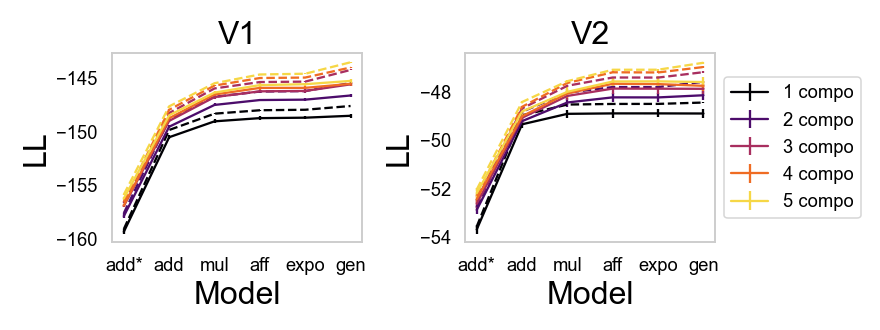

In [105]:
fig,ax = plt.subplots(1,2, figsize=(8,3))
for i in range(n_compo_len):
    ax[0].errorbar(np.arange(6), np.mean(ll_train1_all[:,i,:],1),np.std(ll_train1_all[:,i,:],1)/np.sqrt(n_fold),linestyle='--', color=colors[i])
    ax[0].errorbar(np.arange(6), np.mean(ll_test1_all[:,i,:],1),np.std(ll_test1_all[:,i,:],1)/np.sqrt(n_fold), color=colors[i])
    
    ax[1].errorbar(np.arange(6), np.mean(ll_train2_all[:,i,:],1),np.std(ll_train2_all[:,i,:],1)/np.sqrt(n_fold),linestyle='--', color=colors[i])
    ax[1].errorbar(np.arange(6), np.mean(ll_test2_all[:,i,:],1),np.std(ll_test2_all[:,i,:],1)/np.sqrt(n_fold), color=colors[i], label='%d compo'%(i+1))
    

ax[0].set_title('V1')
ax[1].set_title('V2')

plt.sca(ax[0])
plt.xticks([0,1,2,3,4,5], ['add*', 'add', 'mul', 'aff','expo', 'gen'])
plt.ylabel('LL')
plt.xlabel('Model')


plt.sca(ax[1])
plt.xticks([0,1,2,3,4,5], ['add*', 'add', 'mul', 'aff','expo', 'gen'])
plt.ylabel('LL')
plt.xlabel('Model')
plt.legend()


# Shrink current axis by 20%
box = ax[1].get_position()
ax[1].set_position([box.x0, box.y0, box.width * 1, box.height])

# Put a legend to the right of the current axis
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()

<IPython.core.display.Javascript object>


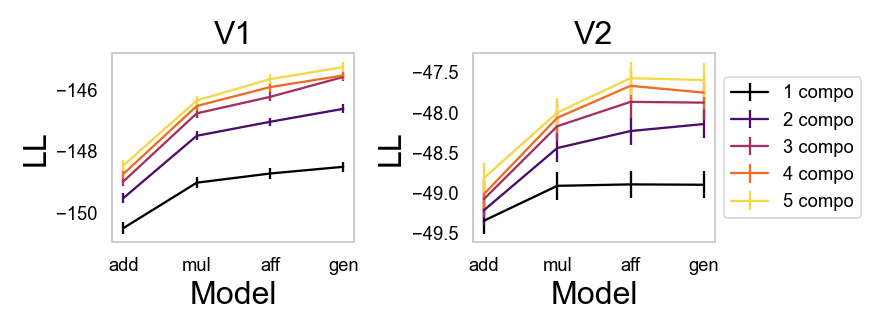

In [106]:
model_ls = [1,2,3,5]

fig,ax = plt.subplots(1,2, figsize=(8,3))
for i in range(n_compo_len):
    #ax[0].errorbar(np.arange(4), np.mean(ll_train1_all[model_ls,i,:],1),np.std(ll_train1_all[model_ls,i,:],1)/np.sqrt(n_fold),linestyle='--', color=colors[i])
    ax[0].errorbar(np.arange(4), np.mean(ll_test1_all[model_ls,i,:],1),np.std(ll_test1_all[model_ls,i,:],1)/np.sqrt(n_fold), color=colors[i])
    
    #ax[1].errorbar(np.arange(4), np.mean(ll_train2_all[model_ls,i,:],1),np.std(ll_train2_all[model_ls,i,:],1)/np.sqrt(n_fold),linestyle='--', color=colors[i])
    ax[1].errorbar(np.arange(4), np.mean(ll_test2_all[model_ls,i,:],1),np.std(ll_test2_all[model_ls,i,:],1)/np.sqrt(n_fold), color=colors[i], label='%d compo'%(i+1))
    

ax[0].set_title('V1')
ax[1].set_title('V2')

plt.sca(ax[0])
plt.xticks([0,1,2,3], [ 'add', 'mul', 'aff','gen'])
plt.ylabel('LL',fontsize=MEDIUM_SIZE)
plt.xlabel('Model',fontsize=MEDIUM_SIZE)


plt.sca(ax[1])
plt.xticks([0,1,2,3], ['add', 'mul', 'aff','gen'])
plt.ylabel('LL',fontsize=MEDIUM_SIZE)
plt.xlabel('Model',fontsize=MEDIUM_SIZE)
plt.legend()


# Shrink current axis by 20%
box = ax[1].get_position()
ax[1].set_position([box.x0, box.y0, box.width * 1, box.height])

# Put a legend to the right of the current axis
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
#plt.savefig('2023_fig/utah_array_stats_model/dataset1_only_test_LL.pdf', transparent=True)

## Plot fitting performance ($R^2$ of noise covariance) of statistical models

In [23]:
def calculate_nc(V1_f,n1, n_trial, n_stim=8):
    #calculate noise covariance 
    V1_spks_res = np.zeros((n_trial*n_stim, n1)) 
    for stim_i in range(n_stim):
        trial_avg = np.mean(V1_f[:, n_trial*stim_i: n_trial*(stim_i+1)],1)
        V1_spks_res[n_trial*stim_i: n_trial*(stim_i+1),:] = (V1_f[:,n_trial*stim_i: n_trial*(stim_i+1)] - trial_avg[:,np.newaxis]).T

    ncov_V1 = np.zeros((n1, n1, n_stim)) 
    
    ## plot nc with axis centered around neurons' whose pref ori match with the input
    for stim_i0 in range(n_stim):
        ncov_V1[:,:, stim_i0] = np.cov(V1_spks_res[n_trial*stim_i0: n_trial*(stim_i0 + 1), :].T)

    return ncov_V1

def calculate_r2_nc(ncov_V1, ncov_V1_add, n1, n_stim=8):
    #ncov from data
    x1 = np.zeros((int(n1*(n1-1)/2), n_stim))
    
    #ncov from model
    x2 = np.zeros((int(n1*(n1-1)/2), n_stim))
    
    for stim_i in range(n_stim):
        tmp = ncov_V1[:,:, stim_i]
        x1[:, stim_i] = tmp[np.triu_indices(n1, 1)]
        
        tmp = ncov_V1_add[:,:, stim_i]
        x2[:, stim_i] = tmp[np.triu_indices(n1, 1)]
        
    r2 = r2_score(x1, x2)
    return r2

In [24]:
def calculate_ncov_from_phi(phi):
    #phi is n x n_compo x n_stim 
    ncov = np.einsum('ijk, ljk->ilk', phi, phi)
    return ncov

def calculate_phi_from_model(add_model, add_varp_model, mul_model, aff_model, expo_model,gen_model,  n_stim=8):
    phi_add = np.tile(add_model.h_p[:,:, None], (1,1,n_stim))
    
    phi_add_varp = np.tile(add_varp_model.h_p[:,:,None].detach().numpy(), (1,1,n_stim))
    
    phi_mul_tmp = mul_model.alpha_p[:,:,None]*mul_model.d_p[:,None,:]
    phi_mul = phi_mul_tmp.detach().numpy()
    
    phi_aff_tmp = aff_model.alpha_p[:,:,None]*aff_model.d_p[:,None,:]+aff_model.beta_p[:,:,None]
    phi_aff = phi_aff_tmp.detach().numpy()
    
    phi_gen = gen_model.F_p
    
    phi_expo_tmp = expo_model.alpha_p[:,:,None]*(expo_model.d_p[:,None,:]**expo_model.expo_p)+expo_model.beta_p[:,:,None]
    phi_expo = phi_expo_tmp.detach().numpy()
    
    return phi_add, phi_add_varp, phi_mul, phi_aff, phi_expo, phi_gen

In [107]:
r2_nc_V1_all = np.zeros((6, n_compo_len, n_fold))
r2_nc_V2_all = np.zeros((6, n_compo_len, n_fold))

for j in range(n_fold):

    train_ind = train_ind_all[j]
    test_ind = test_ind_all[j]

    V1_f_train = V1_f_[:,train_ind,:].reshape((n1, -1), order='F')
    V1_f_test = V1_f_[:,test_ind,:].reshape((n1, -1), order='F')

    V2_f_train = V2_f_[:,train_ind,:].reshape((n2, -1), order='F')
    V2_f_test = V2_f_[:,test_ind,:].reshape((n2, -1), order='F')

    x1 = V1_f_train.reshape(n1, -1, order='F')
    x_test1 = V1_f_test.reshape(n1, -1, order='F')

    x2 = V2_f_train.reshape(n2, -1, order='F')
    x_test2 = V2_f_test.reshape(n2, -1, order='F')
    
    for i in range(n_compo_len):
        add_model_V1 = add_model_V1_all[i+j*n_compo_len]
        add_varp_model_V1 = add_varp_model_V1_all[i+j*n_compo_len]
        mul_model_V1 = mul_model_V1_all[i+j*n_compo_len]
        aff_model_V1 = aff_model_V1_all[i+j*n_compo_len]
        gen_model_V1 = gen_model_V1_all[i+j*n_compo_len]
        expo_model_V1 = expo_model_V1_all[i+j*n_compo_len]

        add_model_V2 = add_model_V2_all[i+j*n_compo_len]
        add_varp_model_V2 = add_varp_model_V2_all[i+j*n_compo_len]
        mul_model_V2 = mul_model_V2_all[i+j*n_compo_len]
        aff_model_V2 = aff_model_V2_all[i+j*n_compo_len]
        gen_model_V2 = gen_model_V2_all[i+j*n_compo_len]
        expo_model_V2 = expo_model_V2_all[i+j*n_compo_len]

        ncov_V1= calculate_nc(x_test1, n1, n_trial_test, n_stim)
        ncov_V2= calculate_nc(x_test2, n2, n_trial_test, n_stim)
        
        phi_V1 = calculate_phi_from_model(add_model_V1, add_varp_model_V1, mul_model_V1, aff_model_V1, expo_model_V1, gen_model_V1, n_stim=8)
        phi_V2 = calculate_phi_from_model(add_model_V2, add_varp_model_V2, mul_model_V2, aff_model_V2, expo_model_V2, gen_model_V2, n_stim=8)
        
        ncov_from_phi_V1 = [np.zeros((n1,n1,n_stim))]*6
        ncov_from_phi_V2 = [np.zeros((n2,n2,n_stim))]*6
        
        for model_i, phi in enumerate(phi_V1):
            ncov_from_phi_V1[model_i] = calculate_ncov_from_phi(phi)
            
        for model_i, phi in enumerate(phi_V2):
            ncov_from_phi_V2[model_i] = calculate_ncov_from_phi(phi)
        
        #plot r2 for ncov_V1
        ncov_V1_models = ncov_from_phi_V1
        ncov_V2_models = ncov_from_phi_V2
        
        
        r2_nc_V1 = []
        r2_nc_V2 = []        
        
        for ncov_V1_model, ncov_V2_model in zip(ncov_V1_models, ncov_V2_models):

            r2_model = calculate_r2_nc(ncov_V1, ncov_V1_model, n1, n_stim)
            r2_nc_V1.append(r2_model)
            
            r2_model = calculate_r2_nc(ncov_V2, ncov_V2_model, n2, n_stim)
            r2_nc_V2.append(r2_model)
            
        r2_nc_V1_all[:,i,j] = r2_nc_V1
        r2_nc_V2_all[:,i,j] = r2_nc_V2
        
        

<IPython.core.display.Javascript object>


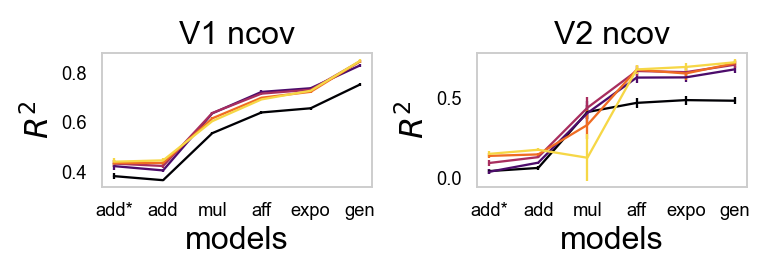

In [108]:
fig, ax = plt.subplots(1,2,figsize=(7,2.5))

for i in range(n_compo_len):
    ax[0].errorbar(range(6), np.mean(r2_nc_V1_all[:,i,:],1),np.std(r2_nc_V1_all[:,i,:],1)/np.sqrt(n_fold) , c = colors[i])
    ax[1].errorbar(range(6), np.mean(r2_nc_V2_all[:,i,:],1),np.std(r2_nc_V2_all[:,i,:],1)/np.sqrt(n_fold) , c = colors[i], label='%d ')
    
model_label=['add*', 'add','mul', 'aff', 'expo','gen']

plt.sca(ax[0])
plt.xticks(range(len(model_label)), model_label)
plt.ylabel('$R^2$')
plt.xlabel('models')
plt.title('V1 ncov')

plt.sca(ax[1])
plt.xticks(range(len(model_label)), model_label)
plt.ylabel('$R^2$')
plt.xlabel('models')
plt.title('V2 ncov')


plt.tight_layout()

<IPython.core.display.Javascript object>


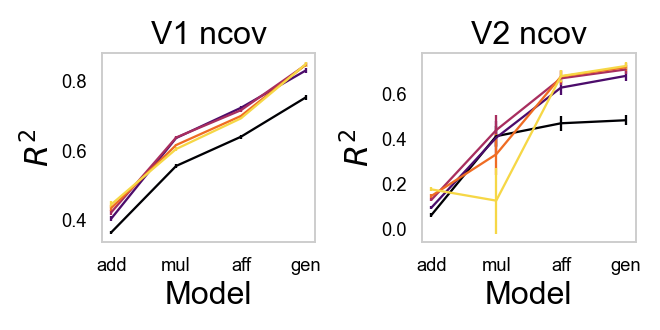

In [109]:
fig, ax = plt.subplots(1,2,figsize=(6,3))

for i in range(n_compo_len):
    ax[0].errorbar(range(4), np.mean(r2_nc_V1_all[model_ls,i,:],1),np.std(r2_nc_V1_all[model_ls,i,:],1)/np.sqrt(n_fold) , c = colors[i])
    ax[1].errorbar(range(4), np.mean(r2_nc_V2_all[model_ls,i,:],1),np.std(r2_nc_V2_all[model_ls,i,:],1)/np.sqrt(n_fold) , c = colors[i], label='%d ')
    
model_label1=['add','mul', 'aff', 'gen']

plt.sca(ax[0])
plt.xticks(range(len(model_label1)), model_label1)
plt.ylabel('$R^2$',fontsize=MEDIUM_SIZE)
plt.xlabel('Model',fontsize=MEDIUM_SIZE)
plt.title('V1 ncov')

plt.sca(ax[1])
plt.xticks(range(len(model_label1)), model_label1)
plt.ylabel('$R^2$',fontsize=MEDIUM_SIZE)
plt.xlabel('Model',fontsize=MEDIUM_SIZE)
plt.title('V2 ncov')


plt.tight_layout()
#plt.savefig('2023_fig/utah_array_stats_model/dataset3_R2.pdf', transparent=True)

## Visualize the amplitude of shared variability $\phi$ from the fitted statistical models

In [144]:
## visualize phi and d
def plot_shared_noise_coef(d, phi_V1, tuning_order):
    n = len(tuning_order)
    
    
    plt.figure(figsize=(10,3))
    ax1 = plt.subplot(151)
    plt.imshow(d[tuning_order,:], aspect='auto', cmap='viridis')#, vmin=0, vmax=np.max(gen_model.d_p))
    plt.title('Trial-avg',fontsize=MEDIUM_SIZE)
    plt.ylabel('Neuron',fontsize=MEDIUM_SIZE)
    plt.xlabel('Stim',fontsize=MEDIUM_SIZE)
    plt.yticks([0, n-1],[1,n])
    plt.xticks(range(8),[1] + [" "]*6 + [8])
    ax1.tick_params(bottom=True)
    cbar = plt.colorbar()
    
    bbox = cbar.ax.get_position()
    plt.text(bbox.x0 + bbox.width / 2, 1.02, '(Hz)', transform=cbar.ax.transAxes, va='bottom', ha='left')

    
    comp_ind=0

    F_p = phi_V1[5][:,comp_ind,:]
    for stim_i in range(n_stim):
    # unify the sign of F_p across stimuli. 
        if stim_i ==0:
            ref_F = F_p[:,0]
        else:
            sign = (np.sum(ref_F * F_p[:, stim_i]) > np.sum(-ref_F * F_p[:, stim_i]))
            if not sign:
                F_p[:, stim_i] *= -1

    if np.sum(ref_F)<0:
        F_p = F_p*-1

    ax5 = plt.subplot(155)
    plt.title(model_label[5],fontsize=MEDIUM_SIZE)
    plt.xlabel('Stim',fontsize=MEDIUM_SIZE)
    plt.xticks(range(8),[1] + [" "]*6 + [8])
    plt.yticks([0],[' '])
    ax5.tick_params(bottom=True)
    plt.imshow(F_p[tuning_order,:], aspect='auto', vmin=np.min(F_p), vmax=np.max(F_p))
    plt.colorbar()

    ax3 = plt.subplot(153)
    plt.imshow(phi_V1[2][tuning_order,0,:], aspect='auto', vmin=np.min(F_p), vmax=np.max(F_p))
    plt.title(model_label[2],fontsize=MEDIUM_SIZE)
    plt.xlabel('Stim',fontsize=MEDIUM_SIZE)
    plt.xticks(range(8),[1] + [" "]*6 + [8])
    plt.yticks([])
    plt.colorbar()
    ax3.tick_params(bottom=True)
    
    ax4 = plt.subplot(154)
    plt.imshow(phi_V1[3][tuning_order,0,:], aspect='auto', vmin=np.min(F_p), vmax=np.max(F_p))
    plt.title(model_label[3],fontsize=MEDIUM_SIZE)
    plt.xlabel('Stim',fontsize=MEDIUM_SIZE)
    plt.xticks(range(8),[1] + [" "]*6 + [8])
    plt.yticks([])
    plt.colorbar()
    ax4.tick_params(bottom=True)

    ax2 = plt.subplot(152)
    plt.title(model_label[1],fontsize=MEDIUM_SIZE)
    plt.xlabel('Stim',fontsize=MEDIUM_SIZE)
    plt.xticks(range(8),[1] + [" "]*6 + [8])
    plt.yticks([])
    plt.imshow(phi_V1[1][tuning_order,0,:], aspect='auto', vmin=np.min(F_p), vmax=np.max(F_p))
    plt.colorbar()
    ax2.tick_params(bottom=True)
    plt.tight_layout()



In [154]:
for j in range(1):

    train_ind = train_ind_all[j]
    test_ind = test_ind_all[j]

    V1_f_train = V1_f_[:,train_ind,:].reshape((n1, -1), order='F')
    V1_f_test = V1_f_[:,test_ind,:].reshape((n1, -1), order='F')

    V2_f_train = V2_f_[:,train_ind,:].reshape((n2, -1), order='F')
    V2_f_test = V2_f_[:,test_ind,:].reshape((n2, -1), order='F')

    x1 = V1_f_train.reshape(n1, -1, order='F')
    x_test1 = V1_f_test.reshape(n1, -1, order='F')

    x2 = V2_f_train.reshape(n2, -1, order='F')
    x_test2 = V2_f_test.reshape(n2, -1, order='F')
    
    for i in range(1):
        add_model_V1 = add_model_V1_all[i+j*n_compo_len]
        add_varp_model_V1 = add_varp_model_V1_all[i+j*n_compo_len]
        mul_model_V1 = mul_model_V1_all[i+j*n_compo_len]
        aff_model_V1 = aff_model_V1_all[i+j*n_compo_len]
        gen_model_V1 = gen_model_V1_all[i+j*n_compo_len]
        expo_model_V1 = expo_model_V1_all[i+j*n_compo_len]

        add_model_V2 = add_model_V2_all[i+j*n_compo_len]
        add_varp_model_V2 = add_varp_model_V2_all[i+j*n_compo_len]
        mul_model_V2 = mul_model_V2_all[i+j*n_compo_len]
        aff_model_V2 = aff_model_V2_all[i+j*n_compo_len]
        gen_model_V2 = gen_model_V2_all[i+j*n_compo_len]
        expo_model_V2 = expo_model_V2_all[i+j*n_compo_len]
        
        phi_V1 = calculate_phi_from_model(add_model_V1, add_varp_model_V1, mul_model_V1, aff_model_V1, expo_model_V1, gen_model_V1, n_stim=8)
        phi_V2 = calculate_phi_from_model(add_model_V2, add_varp_model_V2, mul_model_V2, aff_model_V2, expo_model_V2, gen_model_V2, n_stim=8)
        

model_label = ['add*', 'Additive', 'Multiplicative', 'Affine', 'expo', 'Generalized']

<IPython.core.display.Javascript object>


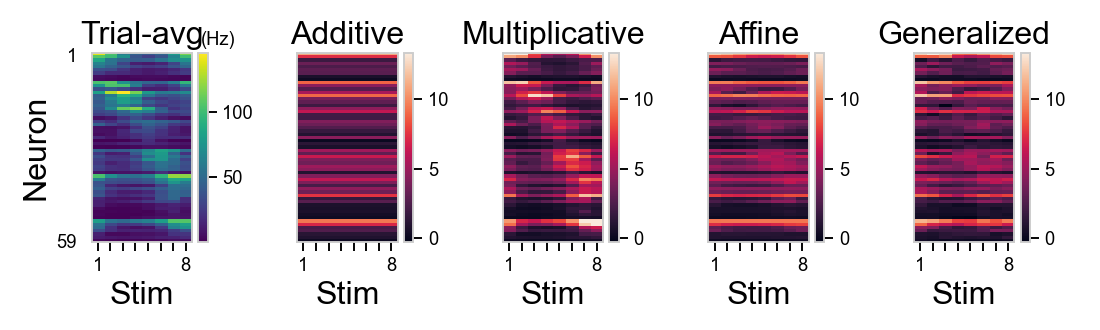

In [156]:
plot_shared_noise_coef(gen_model_V1.d_p, phi_V1, tuning_order_V1)
#plt.savefig('2023_fig/utah_array_stats_model/dataset4_phi_V1_revised.pdf', transparent='True')

<IPython.core.display.Javascript object>


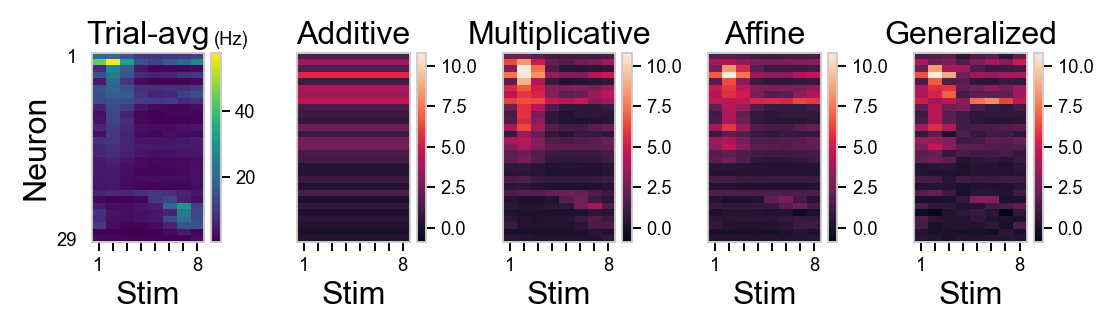

In [158]:
plot_shared_noise_coef(gen_model_V2.d_p, phi_V2, tuning_order_V2)
#plt.savefig('2023_fig/utah_array_stats_model/dataset4_phi_V2_revised.pdf', transparent='True')

## Visualize the variance of private variability from the fitted statistical models

In [88]:
def plot_private_noise(d, psi_add_varp, psi_mul, psi_aff, psi_gen, tuning_order, title):
    n = len(tuning_order)
    
    plt.figure(figsize=(14,3.5))
    plt.suptitle(title)
    plt.subplot(151)
    plt.imshow(d[tuning_order,:], aspect='auto', cmap='viridis', vmin=0, vmax=np.max(d))
    plt.title('Trial-avg',fontsize=MEDIUM_SIZE)
    plt.ylabel('Neuron',fontsize=MEDIUM_SIZE)
    plt.xlabel('Stim',fontsize=MEDIUM_SIZE)
    plt.yticks([0, n-1],[1,n])
    plt.xticks(range(8),[1] + [" "]*6 + [8])
    plt.tick_params(bottom=True)
    cbar = plt.colorbar()
    
    bbox = cbar.ax.get_position()
    plt.text(bbox.x0 + bbox.width / 2, 1.02, '(Hz)', transform=cbar.ax.transAxes, va='bottom', ha='left')

    plt.subplot(152)
    plt.imshow((psi_add_varp).detach().cpu().numpy()[tuning_order,:], aspect='auto', vmin=0, vmax=np.max(psi_gen), cmap='plasma')
    plt.title('Additive')
    plt.xlabel('Stim',fontsize=MEDIUM_SIZE)
    plt.xticks(range(8),[1] + [" "]*6 + [8])
    plt.yticks([0],[' '])
    plt.tick_params(bottom=True)
    plt.colorbar()
    
    plt.subplot(153)
    plt.imshow((psi_add_varp).detach().cpu().numpy()[tuning_order,:], aspect='auto', vmin=0, vmax=np.max(psi_gen), cmap='plasma')
    plt.title('Multiplicative')
    plt.xlabel('Stim',fontsize=MEDIUM_SIZE)
    plt.xticks(range(8),[1] + [" "]*6 + [8])
    plt.yticks([0],[' '])
    plt.tick_params(bottom=True)
    plt.colorbar()

    plt.subplot(154)
    plt.imshow((psi_mul).detach().cpu().numpy()[tuning_order,:], aspect='auto', vmin=0, vmax=np.max(psi_gen), cmap='plasma')
    plt.title('Affine')
    plt.xlabel('Stim',fontsize=MEDIUM_SIZE)
    plt.xticks(range(8),[1] + [" "]*6 + [8])
    plt.yticks([0],[' '])
    plt.tick_params(bottom=True)
    plt.colorbar()

    plt.subplot(155)
    plt.imshow(psi_gen[tuning_order,:], aspect='auto', vmin=0, vmax=np.max(psi_gen), cmap='plasma')
    plt.title('Generalized')
    plt.xlabel('Stim',fontsize=MEDIUM_SIZE)
    plt.xticks(range(8),[1] + [" "]*6 + [8])
    plt.yticks([0],[' '])
    plt.tick_params(bottom=True)
    plt.colorbar()
    plt.tight_layout()

<IPython.core.display.Javascript object>


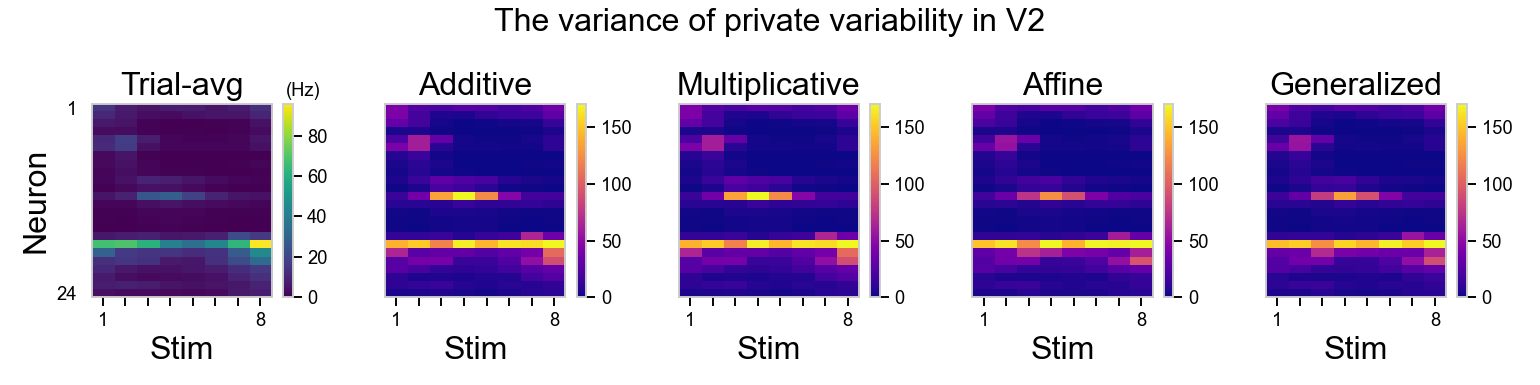

In [142]:
plot_private_noise(gen_model_V2_all[0].d_p, add_varp_model_V2_all[0].psi_p, mul_model_V2_all[0].psi_p, aff_model_V2_all[0].psi_p, gen_model_V2_all[0].psi_p, tuning_order_V2,'The variance of private variability in V2')

#plt.savefig('2023_fig/utah_array_stats_model/dataset1_comp1_private_noise_V2_revised.pdf', transparent=True)

<IPython.core.display.Javascript object>


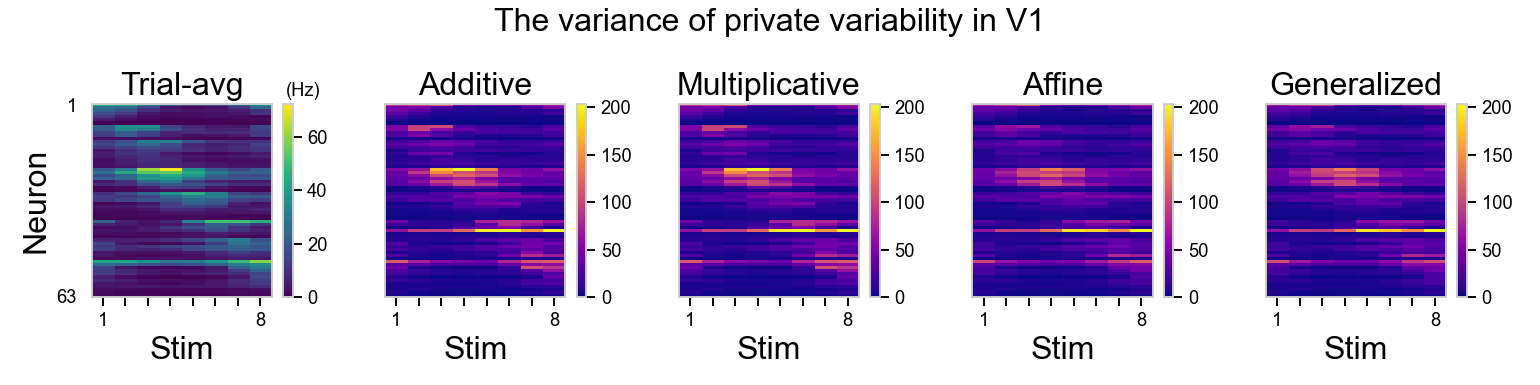

In [143]:
plot_private_noise(gen_model_V1_all[0].d_p, add_varp_model_V1_all[0].psi_p, mul_model_V1_all[0].psi_p, aff_model_V1_all[0].psi_p, gen_model_V1_all[0].psi_p, tuning_order_V1,'The variance of private variability in V1')

#plt.savefig('2023_fig/utah_array_stats_model/dataset1_comp1_private_noise_V1_revised.pdf', transparent=True)